In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from glob import glob
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

import shutil

# Project
project_common_path = os.path.dirname('.')
project_common_path = os.path.abspath(os.path.join(project_common_path, '..', 'common'))
if not project_common_path in sys.path:
    sys.path.append(project_common_path)

In [3]:
from data_utils import RESOURCES_PATH, GENERATED_DATA, get_annotations
from data_utils import get_id_type_list_from_annotations
from image_utils import get_image_data

In [4]:
sloth_annotations_filename = os.path.join(RESOURCES_PATH, 'cervix_os.json')
annotations = get_annotations(sloth_annotations_filename)
print("Number of hand-made annotations: ", len(annotations))

trainval_id_type_list = get_id_type_list_from_annotations(annotations, select=['os', 'cervix', 'ok'])
bad_id_type_list = get_id_type_list_from_annotations(annotations, select=['to_remove', ])
print(len(trainval_id_type_list), len(bad_id_type_list))

## Remove green imagery
from data_utils import remove_green_imagery
trainval_id_type_list = remove_green_imagery(trainval_id_type_list)
print(len(trainval_id_type_list))

Number of hand-made annotations:  4483
2839 1644
2821


In [5]:
import numpy as np
from data_utils import compute_type_distribution
compute_type_distribution(np.array(trainval_id_type_list))

[0.32825239276852181, 0.33002481389578164, 0.34172279333569655]

In [6]:
from xy_providers import DataCache
try:
    if cache is None:
        cache = DataCache(0)
except NameError:
    cache = DataCache(0)

In [7]:
# os.environ['KERAS_BACKEND']='tensorflow'

# from custom_squeezenet_sb_bn import get_cnn
from custom_squeezenet import get_cnn

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5110)


In [8]:
from keras import backend as K
print(K.backend(), K.image_dim_ordering())

theano tf


In [10]:
cnn = get_cnn()
cnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3_1 (InputLayer)           (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
input_4_2 (InputLayer)           (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv1_1 (Conv2D)                 (None, 149, 149, 64)  1792        input_3_1[0][0]                  
____________________________________________________________________________________________________
conv1_2 (Conv2D)                 (None, 149, 149, 64)  1792        input_4_2[0][0]                  
___________________________________________________________________________________________

In [ ]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

SVG(model_to_dot(cnn, show_shapes=True).create(prog='dot', format='svg'))

In [31]:
exp_decay(30, lr=1.0, a=0.987)

0.67705687449816443

In [ ]:
# ####################################################
#  Setup NN parameters
# ####################################################
from cv_utils import generate_trainval_kfolds
from data_utils import to_set
from training_utils import classification_train as train, classification_validate as validate
from training_utils import find_best_weights_file2

seed = 54321
optimizer = 'adadelta'
image_size = (299, 299)

nb_epochs = 45
batch_size = 8
lr_base = 1.0
init_epoch = 30
a = 0.987

load_best_weights = True


# ####################################################
#  Start CV
# ####################################################
from training_utils import exp_decay, step_decay

n_folds = 6
val_fold_index = 0
val_fold_indices = [0,]

hists = []

for train_id_type_list, val_id_type_list in generate_trainval_kfolds(np.array(trainval_id_type_list), n_folds, seed=seed):
    
    if len(val_fold_indices) > 0:
        if val_fold_index not in val_fold_indices:
            val_fold_index += 1
            continue
        
    save_prefix = 'cnn_bn_os_cervix_class_cvfold=%i_opt=%s_seed=%i' % (val_fold_index, optimizer, seed)
    print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)
    val_fold_index += 1

    print(len(train_id_type_list), len(val_id_type_list))
    assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"
    print(compute_type_distribution(train_id_type_list))
    print(compute_type_distribution(val_id_type_list))

    print("\n {} - Get custom squeezenet model ...".format(datetime.now()))
    if load_best_weights:
        weights = None
    else:
        weights = 'imagenet'
    cnn = get_cnn3(optimizer=optimizer, lr=lr_base, weights=weights)

    if load_best_weights:
        weights_files = glob("weights/%s*.h5" % save_prefix)
        if len(weights_files) > 0:
            best_weights_filename, best_val_loss = find_best_weights_file2(weights_files, field_name='val_loss')
            print("Load best loss weights: ", best_weights_filename, best_val_loss)
            cnn.load_weights(best_weights_filename, by_name=True)

    # lrate_decay_f = lambda epoch: step_decay(epoch, lr=lr_base, base=2.0, period=7)
    lrate_decay_f = lambda epoch: exp_decay(epoch, lr=lr_base, a=a, init_epoch=init_epoch)
    # lrate_decay_f = None
    
    np.random.seed(seed)
    print("\n {} - Start training ...".format(datetime.now()))
    h = train(cnn,
              train_id_type_list,
              val_id_type_list,
              option='cervix/os', 
              normalize_data=True,
              normalization='vgg',
              nb_epochs=nb_epochs,
              samples_per_epoch=2 * len(train_id_type_list),
              nb_val_samples=len(val_id_type_list),
              lrate_decay_f=lrate_decay_f,
              batch_size=batch_size,
              xy_provider_cache=cache,
              image_size=image_size[::-1],
              seed=seed,              
              save_prefix=save_prefix)    
    if h is None:
        continue
    hists.append(h)   
    



 ---- Validation fold index:  0 / 6
2386 483
[0.33654652137468566, 0.33319362950544845, 0.33025984911986589]
[0.30848861283643897, 0.32712215320910976, 0.36438923395445139]

 2017-05-27 23:11:11.909507 - Get custom squeezenet model ...
Load best loss weights:  weights/cnn_bn_os_cervix_class_cvfold=0_opt=adadelta_seed=54321_27_val_loss=0.8635_val_acc=0.6025_val_precision=0.6527_val_recall=0.4713.h5 0.8635

 2017-05-27 23:11:27.087797 - Start training ...

-- Training parameters: 8, 45, 4776, 488

-- Fit model
Image normalization:  vgg
Image normalization:  vgg
Image normalization:  vgg
Image normalization:  vgg
- New Keras API found -
Epoch 1/45
 22/597 [>.............................] - ETA: 704s - loss: 0.9490 - acc: 0.5795 - precision: 0.6282 - recall: 0.4034

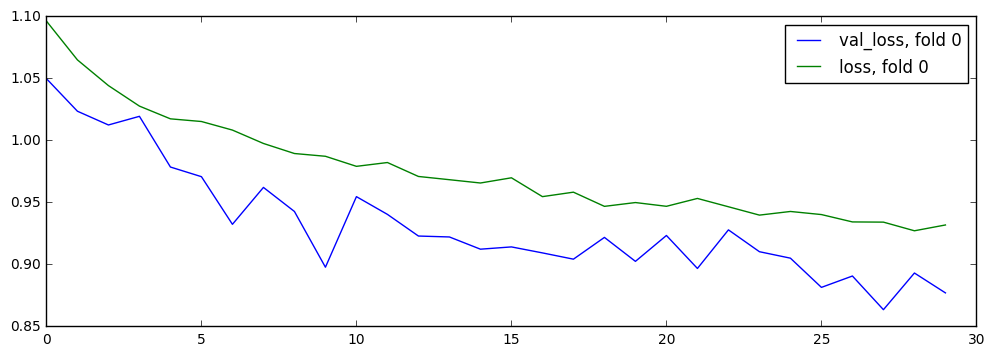

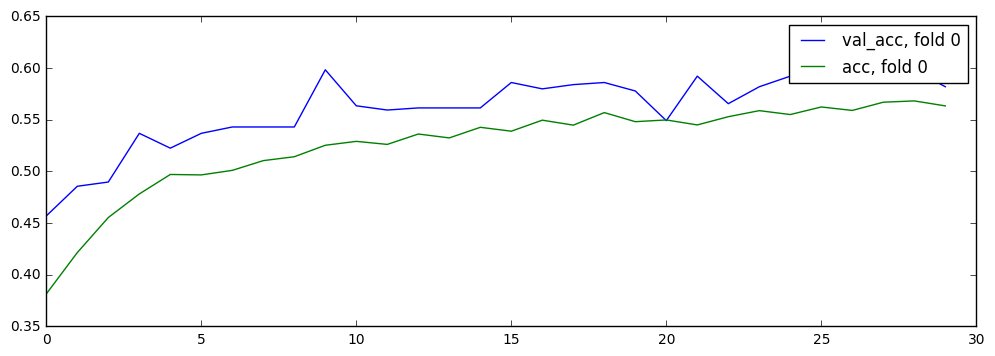

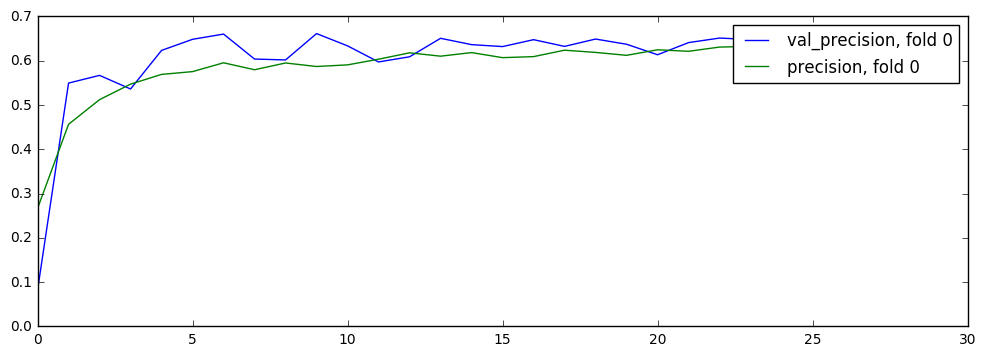

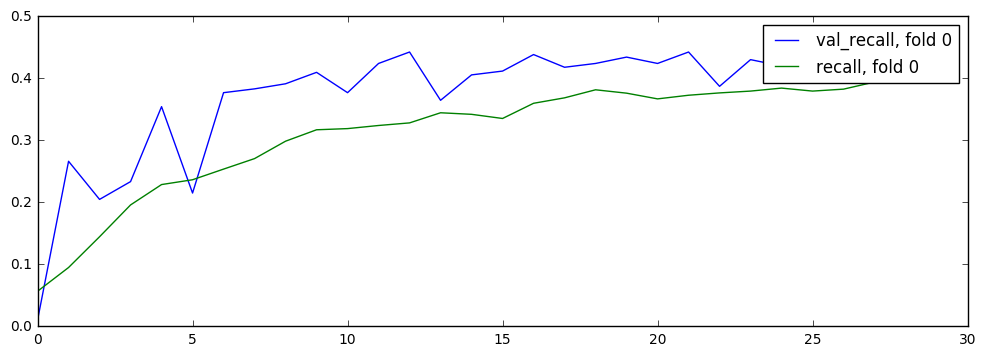

In [26]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(12, 4))
ll = len(hists)
for i, h in enumerate(hists):
    plt.subplot(1, ll, i+1)
    plt.plot(h.history['val_loss'], label='val_loss, fold %i' % i)
    plt.plot(h.history['loss'], label='loss, fold %i' % i)   
    plt.legend()


plt.figure(figsize=(12, 4))
ll = len(hists)
for i, h in enumerate(hists):
    plt.subplot(1, ll, i+1)
    plt.plot(h.history['val_acc'], label='val_acc, fold %i' % i)
    plt.plot(h.history['acc'], label='acc, fold %i' % i)   
    plt.legend()
    
plt.figure(figsize=(12, 4))
ll = len(hists)
for i, h in enumerate(hists):
    plt.subplot(1, ll, i+1)
    plt.plot(h.history['val_precision'], label='val_precision, fold %i' % i)
    plt.plot(h.history['precision'], label='precision, fold %i' % i)   
    plt.legend()
    
plt.figure(figsize=(12, 4))
ll = len(hists)
for i, h in enumerate(hists):
    plt.subplot(1, ll, i+1)
    plt.plot(h.history['val_recall'], label='val_recall, fold %i' % i)
    plt.plot(h.history['recall'], label='recall, fold %i' % i)   
    plt.legend()

In [27]:
## Cross-validation:

n_runs = 3
seed = 54321
run_counter = 0
cv_mean_losses = np.zeros((n_runs, n_folds))

while run_counter < n_runs:    
    run_counter += 1
    print("\n\n ---- New run : ", run_counter, "/", n_runs)
    val_fold_index = 0
    for train_id_type_list, val_id_type_list in generate_trainval_kfolds(np.array(trainval_id_type_list), n_folds, seed=seed):

        save_prefix = 'cnn_os_cervix_class_cvfold=%i_opt=%s_seed=%i' % (val_fold_index, optimizer, seed)
        print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)
        val_fold_index += 1

        print(len(train_id_type_list), len(val_id_type_list))
        assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"
        print(compute_type_distribution(train_id_type_list))
        print(compute_type_distribution(val_id_type_list))

        print("\n {} - Get custom squeezenet model ...".format(datetime.now()))
        cnn = get_cnn(optimizer=optimizer, lr=lr_base)

        weights_files = glob("weights/%s*.h5" % save_prefix)
        assert len(weights_files) > 0, "Failed to load weights"
        best_weights_filename, best_val_loss = find_best_weights_file2(weights_files, field_name='val_loss')
        print("Load best loss weights: ", best_weights_filename, best_val_loss)
        cnn.load_weights(best_weights_filename)

        loss = validate(cnn, 
                        val_id_type_list, 
                        option='cervix/os',
                        normalize_data=True,
                        normalization='vgg',
                        image_size=image_size[::-1],
                        save_prefix=save_prefix,
                        batch_size=8,
                        seed=seed + run_counter,
                        verbose=1,
                        xy_provider_cache=cache)   
        cv_mean_losses[run_counter-1, val_fold_index-1] = loss
    
print(cv_mean_losses)



 ---- New run :  1 / 3


 ---- Validation fold index:  0 / 6
2386 483
[0.33654652137468566, 0.33319362950544845, 0.33025984911986589]
[0.30848861283643897, 0.32712215320910976, 0.36438923395445139]

 2017-05-25 21:06:40.652534 - Get custom squeezenet model ...
Load best loss weights:  weights/cnn_os_cervix_class_cvfold=0_opt=adadelta_seed=54321_26_val_loss=0.8327_val_acc=0.6352_val_precision=0.6709_val_recall=0.5246.h5 0.8327
Image normalization:  vgg
Image normalization:  vgg
Total loss :  0.83999491334


 ---- Validation fold index:  1 / 6
2391 483
[0.33375156838143033, 0.32998745294855708, 0.33626097867001253]
[0.32298136645962733, 0.34575569358178054, 0.33126293995859213]

 2017-05-25 21:07:30.852024 - Get custom squeezenet model ...
Load best loss weights:  weights/cnn_os_cervix_class_cvfold=1_opt=adadelta_seed=54321_19_val_loss=0.8429_val_acc=0.6352_val_precision=0.6949_val_recall=0.4939.h5 0.8429
Image normalization:  vgg
Image normalization:  vgg
Total loss :  0.896009415388


In [71]:
np.mean(cv_mean_losses)

0.86578549218398548

In [36]:
## Predict on test data
from data_utils import test_ids

test_id_type_list = []
for image_id in test_ids:
    test_id_type_list.append((image_id, "Test"))

In [ ]:
from test_utils import classification_predict as predict

predictions = []

for val_fold_index in range(n_folds):
    
    save_prefix = 'cnn_bn_os_cervix_class_cvfold=%i_opt=%s_seed=%i' % (val_fold_index, optimizer, seed)
    print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)
    val_fold_index += 1

    print("\n {} - Get custom squeezenet model ...".format(datetime.now()))
    cnn = get_cnn(optimizer=optimizer, lr=lr_base)

    weights_files = glob("weights/%s*.h5" % save_prefix)
    assert len(weights_files) > 0, "Failed to load weights"
    best_weights_filename, best_val_loss = find_best_weights_file2(weights_files, field_name='val_loss')
    print("Load best loss weights: ", best_weights_filename, best_val_loss)
    cnn.load_weights(best_weights_filename)
    
    df = predict(cnn,
                test_id_type_list, 
                option='cervix/os', 
                normalize_data=True,
                normalization='vgg',
                image_size=image_size[::-1],
                save_prefix=save_prefix,
                batch_size=8,
                seed=seed,
                xy_provider_cache=cache)
    predictions.append(df)
    



 ---- Validation fold index:  0 / 6

 2017-05-28 11:19:40.025825 - Get custom squeezenet model ...
Load best loss weights:  weights/cnn_bn_os_cervix_class_cvfold=0_opt=adadelta_seed=54321_33_val_loss=0.8326_val_acc=0.6168_val_precision=0.6728_val_recall=0.4734.h5 0.8326
Image normalization:  vgg
Image normalization:  vgg
-- 0 / 512
-- 8 / 512
-- 16 / 512
-- 24 / 512


In [37]:
import pandas as pd


def compute_mean(predictions):    
    df = predictions[0]
    for p in predictions[1:]:
        df = pd.concat([df, p], axis=0)
    df = df.apply(pd.to_numeric, errors='ignore')        
    gb = df.groupby('image_name')
    df2 = gb.agg(np.mean).reset_index()
    return df2

df = compute_mean(predictions)
df.head()

NameError: name 'predictions' is not defined

In [100]:
import pandas as pd


def compute_mean(predictions):    
    df = predictions[0]
    for p in predictions[1:]:
        df = pd.concat([df, p], axis=0)
    df = df.apply(pd.to_numeric, errors='ignore')        
    gb = df.groupby('image_name')
    df2 = gb.agg(np.mean).reset_index()
    return df2

df = compute_mean(predictions)
df.head()

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0.222587,0.533222,0.244191
1,1.jpg,0.215771,0.542684,0.241544
2,10.jpg,0.330304,0.534667,0.135029
3,100.jpg,0.300007,0.633719,0.066274
4,101.jpg,0.475317,0.412831,0.111853


In [101]:
from datetime import datetime

info = 'mean_cv=6_squeezenet'

now = datetime.now()
sub_file = 'submission_' + info + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
sub_file = os.path.join('..', 'results', sub_file)
df.to_csv(sub_file, index=False)

### Logs SqueezeNet + simple bypass + BN

After 60 epochs 
```
 ---- Validation fold index:  0 / 6
2386 483
[0.33654652137468566, 0.33319362950544845, 0.33025984911986589]
[0.30848861283643897, 0.32712215320910976, 0.36438923395445139]

 2017-05-27 21:48:38.314348 - Get custom squeezenet model ...
Load best loss weights:  weights/cnn_sb_bn_os_cervix_class_cvfold=0_opt=adadelta_seed=54321_27_val_loss=0.8503_val_acc=0.6291_val_precision=0.6483_val_recall=0.5041.h5 0.8503

 2017-05-27 21:48:50.773432 - Start training ...

-- Training parameters: 8, 45, 4776, 488

-- Fit model
Image normalization:  vgg
Image normalization:  vgg
Image normalization:  vgg
Image normalization:  vgg
- New Keras API found -
Epoch 1/45
597/597 [==============================] - 759s - loss: 0.9044 - acc: 0.5838 - precision: 0.6467 - recall: 0.4382 - val_loss: 0.8706 - val_acc: 0.5984 - val_precision: 0.6415 - val_recall: 0.4918
Epoch 2/45
597/597 [==============================] - 679s - loss: 0.9092 - acc: 0.5844 - precision: 0.6430 - recall: 0.4273 - val_loss: 0.8752 - val_acc: 0.6004 - val_precision: 0.6197 - val_recall: 0.4959
Epoch 3/45
597/597 [==============================] - 699s - loss: 0.9018 - acc: 0.5886 - precision: 0.6467 - recall: 0.4489 - val_loss: 0.8601 - val_acc: 0.6291 - val_precision: 0.6433 - val_recall: 0.4980
Epoch 4/45
597/597 [==============================] - 689s - loss: 0.8996 - acc: 0.5898 - precision: 0.6560 - recall: 0.4537 - val_loss: 0.8648 - val_acc: 0.6230 - val_precision: 0.6598 - val_recall: 0.5225
Epoch 5/45
597/597 [==============================] - 684s - loss: 0.9034 - acc: 0.5858 - precision: 0.6542 - recall: 0.4391 - val_loss: 0.8645 - val_acc: 0.6045 - val_precision: 0.6791 - val_recall: 0.5082
Epoch 6/45
597/597 [==============================] - 694s - loss: 0.9059 - acc: 0.5881 - precision: 0.6549 - recall: 0.4414 - val_loss: 0.8884 - val_acc: 0.6127 - val_precision: 0.6441 - val_recall: 0.4385
Epoch 7/45
162/597 [=======>......................] - ETA: 490s - loss: 0.8905 - acc: 0.5910 - precision: 0.6523 - recall: 0.4313



---- Validation fold index:  0 / 6
2386 483
[0.33654652137468566, 0.33319362950544845, 0.33025984911986589]
[0.30848861283643897, 0.32712215320910976, 0.36438923395445139]

 2017-05-27 18:43:37.634011 - Get custom squeezenet model ...
Load best loss weights:  weights/cnn_sb_bn_os_cervix_class_cvfold=0_opt=adadelta_seed=54321_27_val_loss=0.8503_val_acc=0.6291_val_precision=0.6483_val_recall=0.5041.h5 0.8503

 2017-05-27 18:43:48.638518 - Start training ...

-- Training parameters: 8, 45, 4776, 488

-- Fit model
Image normalization:  vgg
Image normalization:  vgg
Image normalization:  vgg
Image normalization:  vgg
- New Keras API found -
Epoch 1/45
597/597 [==============================] - 774s - loss: 0.9045 - acc: 0.5804 - precision: 0.6436 - recall: 0.4370 - val_loss: 0.8677 - val_acc: 0.5902 - val_precision: 0.6327 - val_recall: 0.4898
Epoch 2/45
597/597 [==============================] - 719s - loss: 0.9073 - acc: 0.5850 - precision: 0.6494 - recall: 0.4376 - val_loss: 0.8787 - val_acc: 0.5963 - val_precision: 0.6143 - val_recall: 0.5000
Epoch 3/45
597/597 [==============================] - 753s - loss: 0.9017 - acc: 0.5909 - precision: 0.6478 - recall: 0.4477 - val_loss: 0.8570 - val_acc: 0.6168 - val_precision: 0.6412 - val_recall: 0.5000
```

## Logs


Squeezenet + simple bypass + BN

```
seed = 54321
optimizer = 'adadelta'
image_size = (299, 299)

nb_epochs = 30
batch_size = 8
lr_base = 1.0
init_epoch = 45
a = 0.987


 ---- Validation fold index:  0 / 6
2386 483
[0.33654652137468566, 0.33319362950544845, 0.33025984911986589]
[0.30848861283643897, 0.32712215320910976, 0.36438923395445139]

 2017-05-27 08:14:36.699119 - Get custom squeezenet model ...
Load best loss weights:  weights/cnn_sb_bn_os_cervix_class_cvfold=0_opt=adadelta_seed=54321_25_val_loss=0.8868_val_acc=0.5779_val_precision=0.6472_val_recall=0.4344.h5 0.8868

 2017-05-27 08:14:45.674928 - Start training ...

-- Training parameters: 8, 30, 4776, 488

-- Fit model
Image normalization:  vgg
Image normalization:  vgg
Image normalization:  vgg
Image normalization:  vgg
- New Keras API found -
Epoch 1/30
597/597 [] - 719s - loss: 0.9374 - acc: 0.5647 - precision: 0.6393 - recall: 0.3834 - val_loss: 0.8956 - val_acc: 0.5656 - val_precision: 0.6485 - val_recall: 0.4365
Epoch 2/30
597/597 [] - 675s - loss: 0.9403 - acc: 0.5590 - precision: 0.6301 - recall: 0.3832 - val_loss: 0.9025 - val_acc: 0.5861 - val_precision: 0.6147 - val_recall: 0.4590
Epoch 3/30
597/597 [] - 670s - loss: 0.9326 - acc: 0.5628 - precision: 0.6341 - recall: 0.4022 - val_loss: 0.8940 - val_acc: 0.5963 - val_precision: 0.6200 - val_recall: 0.4652
Epoch 4/30
597/597 [] - 668s - loss: 0.9266 - acc: 0.5628 - precision: 0.6376 - recall: 0.4106 - val_loss: 0.8906 - val_acc: 0.5881 - val_precision: 0.6431 - val_recall: 0.4816
Epoch 5/30
597/597 [] - 669s - loss: 0.9327 - acc: 0.5674 - precision: 0.6343 - recall: 0.3949 - val_loss: 0.8878 - val_acc: 0.5799 - val_precision: 0.6845 - val_recall: 0.4754
Epoch 6/30
597/597 [] - 669s - loss: 0.9322 - acc: 0.5674 - precision: 0.6384 - recall: 0.4045 - val_loss: 0.8946 - val_acc: 0.6209 - val_precision: 0.6377 - val_recall: 0.4529
Epoch 7/30
597/597 [] - 669s - loss: 0.9307 - acc: 0.5611 - precision: 0.6239 - recall: 0.3892 - val_loss: 0.9009 - val_acc: 0.5902 - val_precision: 0.6261 - val_recall: 0.4488
Epoch 8/30
597/597 [] - 670s - loss: 0.9328 - acc: 0.5613 - precision: 0.6336 - recall: 0.3953 - val_loss: 0.9055 - val_acc: 0.5861 - val_precision: 0.6400 - val_recall: 0.4611
Epoch 9/30
597/597 [] - 671s - loss: 0.9222 - acc: 0.5712 - precision: 0.6448 - recall: 0.4119 - val_loss: 0.9038 - val_acc: 0.5840 - val_precision: 0.6387 - val_recall: 0.4590
Epoch 10/30
597/597 [] - 670s - loss: 0.9303 - acc: 0.5701 - precision: 0.6308 - recall: 0.4137 - val_loss: 0.8624 - val_acc: 0.6270 - val_precision: 0.6730 - val_recall: 0.4508
Epoch 11/30
597/597 [] - 672s - loss: 0.9217 - acc: 0.5722 - precision: 0.6316 - recall: 0.4104 - val_loss: 0.9038 - val_acc: 0.5738 - val_precision: 0.6329 - val_recall: 0.4324
Epoch 12/30
597/597 [] - 673s - loss: 0.9276 - acc: 0.5693 - precision: 0.6383 - recall: 0.4043 - val_loss: 0.9008 - val_acc: 0.6004 - val_precision: 0.6254 - val_recall: 0.4406
Epoch 13/30
597/597 [] - 676s - loss: 0.9201 - acc: 0.5724 - precision: 0.6427 - recall: 0.4077 - val_loss: 0.8802 - val_acc: 0.5963 - val_precision: 0.6273 - val_recall: 0.4734
Epoch 14/30
597/597 [] - 681s - loss: 0.9235 - acc: 0.5628 - precision: 0.6338 - recall: 0.4165 - val_loss: 0.8627 - val_acc: 0.6025 - val_precision: 0.6530 - val_recall: 0.4570
Epoch 15/30
597/597 [] - 684s - loss: 0.9176 - acc: 0.5773 - precision: 0.6404 - recall: 0.4045 - val_loss: 0.8905 - val_acc: 0.6004 - val_precision: 0.6426 - val_recall: 0.4877
Epoch 16/30
597/597 [] - 684s - loss: 0.9206 - acc: 0.5716 - precision: 0.6407 - recall: 0.4102 - val_loss: 0.8694 - val_acc: 0.6066 - val_precision: 0.6854 - val_recall: 0.4795
Epoch 17/30
597/597 [] - 684s - loss: 0.9105 - acc: 0.5745 - precision: 0.6412 - recall: 0.4326 - val_loss: 0.8982 - val_acc: 0.6004 - val_precision: 0.6323 - val_recall: 0.4980
Epoch 18/30
597/597 [] - 681s - loss: 0.9136 - acc: 0.5771 - precision: 0.6453 - recall: 0.4315 - val_loss: 0.8713 - val_acc: 0.6168 - val_precision: 0.6262 - val_recall: 0.5000
Epoch 19/30
597/597 [] - 680s - loss: 0.9090 - acc: 0.5814 - precision: 0.6447 - recall: 0.4366 - val_loss: 0.8919 - val_acc: 0.5840 - val_precision: 0.6128 - val_recall: 0.4570
Epoch 20/30
597/597 [] - 680s - loss: 0.9100 - acc: 0.5775 - precision: 0.6357 - recall: 0.4294 - val_loss: 0.8752 - val_acc: 0.6086 - val_precision: 0.6499 - val_recall: 0.4713
Epoch 21/30
597/597 [] - 681s - loss: 0.9126 - acc: 0.5791 - precision: 0.6474 - recall: 0.4332 - val_loss: 0.8940 - val_acc: 0.6004 - val_precision: 0.6501 - val_recall: 0.4611
Epoch 22/30
597/597 [] - 681s - loss: 0.9183 - acc: 0.5701 - precision: 0.6364 - recall: 0.4196 - val_loss: 0.8549 - val_acc: 0.6168 - val_precision: 0.6838 - val_recall: 0.4611
Epoch 23/30
597/597 [] - 680s - loss: 0.9118 - acc: 0.5838 - precision: 0.6515 - recall: 0.4332 - val_loss: 0.9145 - val_acc: 0.5820 - val_precision: 0.6465 - val_recall: 0.4262
Epoch 24/30
597/597 [] - 680s - loss: 0.9123 - acc: 0.5699 - precision: 0.6463 - recall: 0.4192 - val_loss: 0.9053 - val_acc: 0.5799 - val_precision: 0.6332 - val_recall: 0.4570
Epoch 25/30
597/597 [] - 680s - loss: 0.9120 - acc: 0.5829 - precision: 0.6355 - recall: 0.4282 - val_loss: 0.8841 - val_acc: 0.5512 - val_precision: 0.6251 - val_recall: 0.4652
Epoch 26/30
597/597 [] - 680s - loss: 0.9062 - acc: 0.5785 - precision: 0.6479 - recall: 0.4363 - val_loss: 0.8797 - val_acc: 0.5943 - val_precision: 0.6347 - val_recall: 0.4672
Epoch 27/30
597/597 [] - 681s - loss: 0.9071 - acc: 0.5812 - precision: 0.6460 - recall: 0.4278 - val_loss: 0.8675 - val_acc: 0.6168 - val_precision: 0.6670 - val_recall: 0.4980
Epoch 28/30
597/597 [] - 681s - loss: 0.9071 - acc: 0.5812 - precision: 0.6428 - recall: 0.4324 - val_loss: 0.8503 - val_acc: 0.6291 - val_precision: 0.6483 - val_recall: 0.5041
Epoch 29/30
597/597 [] - 680s - loss: 0.9090 - acc: 0.5718 - precision: 0.6432 - recall: 0.4317 - val_loss: 0.8719 - val_acc: 0.6230 - val_precision: 0.6656 - val_recall: 0.4775
Epoch 30/30
597/597 [] - 680s - loss: 0.9077 - acc: 0.5842 - precision: 0.6518 - recall: 0.4322 - val_loss: 0.8840 - val_acc: 0.5799 - val_precision: 0.6249 - val_recall: 0.4611


 ---- Validation fold index:  1 / 6
2391 483
[0.33375156838143033, 0.32998745294855708, 0.33626097867001253]
[0.32298136645962733, 0.34575569358178054, 0.33126293995859213]

 2017-05-27 13:54:36.946690 - Get custom squeezenet model ...
Load best loss weights:  weights/cnn_sb_bn_os_cervix_class_cvfold=1_opt=adadelta_seed=54321_09_val_loss=0.9148_val_acc=0.6025_val_precision=0.6471_val_recall=0.3053.h5 0.9148

 2017-05-27 13:54:46.766170 - Start training ...

-- Training parameters: 8, 30, 4784, 488

-- Fit model
Image normalization:  vgg
Image normalization:  vgg
Image normalization:  vgg
Image normalization:  vgg
- New Keras API found -
Epoch 1/30
598/598 [] - 726s - loss: 0.9745 - acc: 0.5328 - precision: 0.6128 - recall: 0.3098 - val_loss: 0.9865 - val_acc: 0.5533 - val_precision: 0.6099 - val_recall: 0.4201
Epoch 2/30
598/598 [] - 682s - loss: 0.9744 - acc: 0.5372 - precision: 0.5847 - recall: 0.3288 - val_loss: 0.9292 - val_acc: 0.5758 - val_precision: 0.6338 - val_recall: 0.3791
Epoch 3/30
598/598 [] - 682s - loss: 0.9703 - acc: 0.5376 - precision: 0.6147 - recall: 0.3257 - val_loss: 0.9488 - val_acc: 0.5533 - val_precision: 0.6063 - val_recall: 0.3914
Epoch 4/30
598/598 [] - 682s - loss: 0.9640 - acc: 0.5426 - precision: 0.6087 - recall: 0.3351 - val_loss: 0.9229 - val_acc: 0.5840 - val_precision: 0.6132 - val_recall: 0.4488
Epoch 5/30
598/598 [] - 682s - loss: 0.9586 - acc: 0.5441 - precision: 0.6108 - recall: 0.3562 - val_loss: 0.9290 - val_acc: 0.5820 - val_precision: 0.6465 - val_recall: 0.4467
Epoch 6/30
598/598 [] - 682s - loss: 0.9538 - acc: 0.5424 - precision: 0.6246 - recall: 0.3662 - val_loss: 0.9286 - val_acc: 0.5840 - val_precision: 0.6511 - val_recall: 0.4180
Epoch 7/30
598/598 [] - 682s - loss: 0.9497 - acc: 0.5560 - precision: 0.6187 - recall: 0.3577 - val_loss: 0.9093 - val_acc: 0.5799 - val_precision: 0.6637 - val_recall: 0.4631
Epoch 8/30
598/598 [] - 682s - loss: 0.9445 - acc: 0.5560 - precision: 0.6251 - recall: 0.3763 - val_loss: 0.9108 - val_acc: 0.5820 - val_precision: 0.6390 - val_recall: 0.4836
Epoch 9/30
598/598 [] - 682s - loss: 0.9435 - acc: 0.5566 - precision: 0.6289 - recall: 0.3758 - val_loss: 0.9491 - val_acc: 0.5348 - val_precision: 0.6052 - val_recall: 0.4303
Epoch 10/30
598/598 [] - 682s - loss: 0.9454 - acc: 0.5550 - precision: 0.6258 - recall: 0.3712 - val_loss: 0.8965 - val_acc: 0.6066 - val_precision: 0.6212 - val_recall: 0.3996
Epoch 11/30
598/598 [] - 681s - loss: 0.9492 - acc: 0.5483 - precision: 0.6206 - recall: 0.3645 - val_loss: 0.9004 - val_acc: 0.5861 - val_precision: 0.6736 - val_recall: 0.4324
Epoch 12/30
598/598 [] - 682s - loss: 0.9428 - acc: 0.5669 - precision: 0.6276 - recall: 0.3817 - val_loss: 0.9058 - val_acc: 0.5758 - val_precision: 0.6461 - val_recall: 0.4570
Epoch 13/30
598/598 [] - 682s - loss: 0.9409 - acc: 0.5581 - precision: 0.6213 - recall: 0.3867 - val_loss: 0.9268 - val_acc: 0.5615 - val_precision: 0.6307 - val_recall: 0.4016
Epoch 14/30
598/598 [] - 682s - loss: 0.9383 - acc: 0.5665 - precision: 0.6307 - recall: 0.3913 - val_loss: 0.9351 - val_acc: 0.5369 - val_precision: 0.5999 - val_recall: 0.4344
Epoch 15/30
598/598 [] - 683s - loss: 0.9399 - acc: 0.5573 - precision: 0.6254 - recall: 0.3740 - val_loss: 0.8845 - val_acc: 0.6004 - val_precision: 0.6449 - val_recall: 0.4344
Epoch 16/30
598/598 [] - 683s - loss: 0.9342 - acc: 0.5577 - precision: 0.6256 - recall: 0.3978 - val_loss: 0.9229 - val_acc: 0.5881 - val_precision: 0.6224 - val_recall: 0.4570
Epoch 17/30
598/598 [] - 682s - loss: 0.9333 - acc: 0.5629 - precision: 0.6316 - recall: 0.3976 - val_loss: 0.9126 - val_acc: 0.5758 - val_precision: 0.6349 - val_recall: 0.4672
Epoch 18/30
598/598 [] - 683s - loss: 0.9351 - acc: 0.5615 - precision: 0.6223 - recall: 0.3963 - val_loss: 0.9480 - val_acc: 0.5492 - val_precision: 0.5999 - val_recall: 0.4344
Epoch 19/30
598/598 [] - 682s - loss: 0.9355 - acc: 0.5619 - precision: 0.6250 - recall: 0.3990 - val_loss: 0.9027 - val_acc: 0.5594 - val_precision: 0.6416 - val_recall: 0.4734
Epoch 20/30
598/598 [] - 682s - loss: 0.9280 - acc: 0.5650 - precision: 0.6348 - recall: 0.4051 - val_loss: 0.8633 - val_acc: 0.6189 - val_precision: 0.6936 - val_recall: 0.4836
Epoch 21/30
598/598 [] - 682s - loss: 0.9294 - acc: 0.5625 - precision: 0.6240 - recall: 0.4070 - val_loss: 0.9371 - val_acc: 0.5615 - val_precision: 0.6044 - val_recall: 0.4201
Epoch 22/30
598/598 [] - 683s - loss: 0.9292 - acc: 0.5679 - precision: 0.6334 - recall: 0.4066 - val_loss: 0.9431 - val_acc: 0.5615 - val_precision: 0.6047 - val_recall: 0.4549
Epoch 23/30
598/598 [] - 682s - loss: 0.9213 - acc: 0.5646 - precision: 0.6271 - recall: 0.4045 - val_loss: 0.9165 - val_acc: 0.5697 - val_precision: 0.6018 - val_recall: 0.4549
Epoch 24/30
598/598 [] - 683s - loss: 0.9193 - acc: 0.5698 - precision: 0.6307 - recall: 0.4116 - val_loss: 0.9260 - val_acc: 0.5758 - val_precision: 0.6270 - val_recall: 0.4488
Epoch 25/30
598/598 [] - 719s - loss: 0.9195 - acc: 0.5763 - precision: 0.6369 - recall: 0.4141 - val_loss: 0.9389 - val_acc: 0.5533 - val_precision: 0.6074 - val_recall: 0.4344
```

---
---


```
seed = 54321
optimizer = 'adadelta'
image_size = (299, 299)

nb_epochs = 30
batch_size = 8
lr_base = 1.0
init_epoch = 0
a = 0.987

load_best_weights = False

---- Validation fold index:  0 / 6
2386 483
[0.33654652137468566, 0.33319362950544845, 0.33025984911986589]
[0.30848861283643897, 0.32712215320910976, 0.36438923395445139]

 2017-05-26 23:47:07.809043 - Get custom squeezenet model ...

 2017-05-26 23:47:18.758701 - Start training ...

-- Training parameters: 8, 30, 4776, 488

-- Fit model
Image normalization:  vgg
Image normalization:  vgg
Image normalization:  vgg
Image normalization:  vgg
- New Keras API found -
Epoch 1/30
597/597 [] - 1876s - loss: 1.0961 - acc: 0.3867 - precision: 0.2825 - recall: 0.0563 - val_loss: 1.0883 - val_acc: 0.4180 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
597/597 [] - 674s - loss: 1.0726 - acc: 0.4192 - precision: 0.4027 - recall: 0.0785 - val_loss: 1.0071 - val_acc: 0.4857 - val_precision: 0.5544 - val_recall: 0.1988
Epoch 3/30
597/597 [] - 683s - loss: 1.0503 - acc: 0.4474 - precision: 0.4883 - recall: 0.1244 - val_loss: 0.9796 - val_acc: 0.4918 - val_precision: 0.5802 - val_recall: 0.3320
Epoch 4/30
597/597 [] - 682s - loss: 1.0307 - acc: 0.4732 - precision: 0.5622 - recall: 0.1853 - val_loss: 1.0756 - val_acc: 0.4877 - val_precision: 0.4966 - val_recall: 0.2541
Epoch 5/30
597/597 [] - 683s - loss: 1.0190 - acc: 0.4899 - precision: 0.5707 - recall: 0.2119 - val_loss: 0.9819 - val_acc: 0.5041 - val_precision: 0.5936 - val_recall: 0.3094
Epoch 6/30
597/597 [] - 684s - loss: 1.0165 - acc: 0.4885 - precision: 0.5700 - recall: 0.2232 - val_loss: 0.9792 - val_acc: 0.5307 - val_precision: 0.6158 - val_recall: 0.2623
Epoch 7/30
597/597 [] - 683s - loss: 1.0098 - acc: 0.5029 - precision: 0.5861 - recall: 0.2529 - val_loss: 0.9520 - val_acc: 0.5389 - val_precision: 0.6543 - val_recall: 0.3668
Epoch 8/30
597/597 [] - 683s - loss: 1.0039 - acc: 0.5067 - precision: 0.5594 - recall: 0.2513 - val_loss: 0.9698 - val_acc: 0.5143 - val_precision: 0.5573 - val_recall: 0.3709
Epoch 9/30
597/597 [] - 684s - loss: 0.9985 - acc: 0.5090 - precision: 0.5906 - recall: 0.2778 - val_loss: 0.9595 - val_acc: 0.5328 - val_precision: 0.5787 - val_recall: 0.4385
Epoch 10/30
597/597 [] - 684s - loss: 0.9927 - acc: 0.5203 - precision: 0.5725 - recall: 0.2919 - val_loss: 0.8977 - val_acc: 0.5984 - val_precision: 0.6776 - val_recall: 0.4262
Epoch 11/30
597/597 [] - 683s - loss: 0.9838 - acc: 0.5214 - precision: 0.6000 - recall: 0.3057 - val_loss: 0.9579 - val_acc: 0.5492 - val_precision: 0.5910 - val_recall: 0.3811
Epoch 12/30
597/597 [] - 684s - loss: 0.9868 - acc: 0.5232 - precision: 0.6036 - recall: 0.3070 - val_loss: 1.0533 - val_acc: 0.5061 - val_precision: 0.5062 - val_recall: 0.3607
Epoch 13/30
597/597 [] - 684s - loss: 0.9783 - acc: 0.5304 - precision: 0.6018 - recall: 0.3065 - val_loss: 0.9277 - val_acc: 0.5451 - val_precision: 0.5992 - val_recall: 0.4426
Epoch 14/30
597/597 [] - 684s - loss: 0.9743 - acc: 0.5258 - precision: 0.5976 - recall: 0.3281 - val_loss: 0.9316 - val_acc: 0.5451 - val_precision: 0.6104 - val_recall: 0.3320
Epoch 15/30
597/597 [] - 684s - loss: 0.9730 - acc: 0.5322 - precision: 0.6024 - recall: 0.3187 - val_loss: 0.9171 - val_acc: 0.5799 - val_precision: 0.6433 - val_recall: 0.3975
Epoch 16/30
597/597 [] - 680s - loss: 0.9754 - acc: 0.5310 - precision: 0.6091 - recall: 0.3139 - val_loss: 0.9432 - val_acc: 0.5430 - val_precision: 0.6112 - val_recall: 0.3402
Epoch 17/30
597/597 [] - 680s - loss: 0.9628 - acc: 0.5398 - precision: 0.6127 - recall: 0.3472 - val_loss: 0.9113 - val_acc: 0.5738 - val_precision: 0.6594 - val_recall: 0.4816
Epoch 18/30
597/597 [] - 680s - loss: 0.9637 - acc: 0.5369 - precision: 0.6116 - recall: 0.3522 - val_loss: 0.9047 - val_acc: 0.5861 - val_precision: 0.6181 - val_recall: 0.4385
Epoch 19/30
597/597 [] - 680s - loss: 0.9545 - acc: 0.5473 - precision: 0.6160 - recall: 0.3647 - val_loss: 0.9172 - val_acc: 0.5799 - val_precision: 0.6446 - val_recall: 0.4365
Epoch 20/30
597/597 [] - 680s - loss: 0.9586 - acc: 0.5469 - precision: 0.6016 - recall: 0.3643 - val_loss: 0.9107 - val_acc: 0.5635 - val_precision: 0.6417 - val_recall: 0.4262
Epoch 21/30
597/597 [] - 680s - loss: 0.9583 - acc: 0.5408 - precision: 0.6141 - recall: 0.3507 - val_loss: 0.9485 - val_acc: 0.5717 - val_precision: 0.5960 - val_recall: 0.4078
Epoch 22/30
597/597 [] - 680s - loss: 0.9612 - acc: 0.5452 - precision: 0.6152 - recall: 0.3499 - val_loss: 0.9105 - val_acc: 0.5779 - val_precision: 0.6691 - val_recall: 0.3975
Epoch 23/30
597/597 [] - 680s - loss: 0.9570 - acc: 0.5459 - precision: 0.6188 - recall: 0.3551 - val_loss: 0.9452 - val_acc: 0.5533 - val_precision: 0.6045 - val_recall: 0.3934
Epoch 24/30
597/597 [] - 679s - loss: 0.9558 - acc: 0.5438 - precision: 0.6281 - recall: 0.3629 - val_loss: 0.9254 - val_acc: 0.5451 - val_precision: 0.6453 - val_recall: 0.3832
Epoch 25/30
597/597 [] - 685s - loss: 0.9549 - acc: 0.5419 - precision: 0.6137 - recall: 0.3572 - val_loss: 0.9001 - val_acc: 0.5840 - val_precision: 0.6371 - val_recall: 0.4180
Epoch 26/30
597/597 [] - 687s - loss: 0.9488 - acc: 0.5484 - precision: 0.6148 - recall: 0.3683 - val_loss: 0.8868 - val_acc: 0.5779 - val_precision: 0.6472 - val_recall: 0.4344
Epoch 27/30
597/597 [] - 685s - loss: 0.9432 - acc: 0.5557 - precision: 0.6304 - recall: 0.3807 - val_loss: 0.9021 - val_acc: 0.5943 - val_precision: 0.6309 - val_recall: 0.4590
Epoch 28/30
597/597 [] - 684s - loss: 0.9419 - acc: 0.5559 - precision: 0.6178 - recall: 0.3779 - val_loss: 0.8975 - val_acc: 0.6004 - val_precision: 0.6299 - val_recall: 0.4467
Epoch 29/30
597/597 [] - 684s - loss: 0.9405 - acc: 0.5540 - precision: 0.6260 - recall: 0.3938 - val_loss: 0.9114 - val_acc: 0.5902 - val_precision: 0.6466 - val_recall: 0.4344
Epoch 30/30
597/597 [] - 684s - loss: 0.9437 - acc: 0.5613 - precision: 0.6242 - recall: 0.3792 - val_loss: 0.8941 - val_acc: 0.5861 - val_precision: 0.6599 - val_recall: 0.4549


 ---- Validation fold index:  1 / 6
2391 483
[0.33375156838143033, 0.32998745294855708, 0.33626097867001253]
[0.32298136645962733, 0.34575569358178054, 0.33126293995859213]

 2017-05-27 05:49:03.681047 - Get custom squeezenet model ...

 2017-05-27 05:49:11.666737 - Start training ...

-- Training parameters: 8, 30, 4784, 488

-- Fit model
Image normalization:  vgg
Image normalization:  vgg
Image normalization:  vgg
Image normalization:  vgg
- New Keras API found -
Epoch 1/30
598/598 [] - 705s - loss: 1.0871 - acc: 0.3986 - precision: 0.3563 - recall: 0.0769 - val_loss: 1.1619 - val_acc: 0.4201 - val_precision: 0.4889 - val_recall: 0.2439
Epoch 2/30
598/598 [] - 684s - loss: 1.0599 - acc: 0.4350 - precision: 0.5035 - recall: 0.1233 - val_loss: 1.1011 - val_acc: 0.4508 - val_precision: 0.4929 - val_recall: 0.2643
Epoch 3/30
598/598 [] - 686s - loss: 1.0435 - acc: 0.4498 - precision: 0.5446 - recall: 0.1559 - val_loss: 1.0258 - val_acc: 0.4713 - val_precision: 0.5456 - val_recall: 0.2234
Epoch 4/30
598/598 [] - 686s - loss: 1.0283 - acc: 0.4730 - precision: 0.5533 - recall: 0.1865 - val_loss: 0.9865 - val_acc: 0.5123 - val_precision: 0.6042 - val_recall: 0.2787
Epoch 5/30
598/598 [] - 686s - loss: 1.0178 - acc: 0.4910 - precision: 0.5727 - recall: 0.2201 - val_loss: 0.9919 - val_acc: 0.5287 - val_precision: 0.5596 - val_recall: 0.2213
Epoch 6/30
598/598 [] - 687s - loss: 1.0072 - acc: 0.4931 - precision: 0.5782 - recall: 0.2429 - val_loss: 0.9828 - val_acc: 0.5143 - val_precision: 0.5929 - val_recall: 0.3197
Epoch 7/30
598/598 [] - 686s - loss: 0.9989 - acc: 0.5054 - precision: 0.5769 - recall: 0.2573 - val_loss: 0.9562 - val_acc: 0.5553 - val_precision: 0.6240 - val_recall: 0.3852
Epoch 8/30
598/598 [] - 686s - loss: 0.9962 - acc: 0.5148 - precision: 0.5742 - recall: 0.2609 - val_loss: 0.9824 - val_acc: 0.5533 - val_precision: 0.5508 - val_recall: 0.3934
Epoch 9/30
598/598 [] - 686s - loss: 0.9915 - acc: 0.5161 - precision: 0.5825 - recall: 0.2799 - val_loss: 0.9610 - val_acc: 0.5594 - val_precision: 0.6084 - val_recall: 0.3955
Epoch 10/30
598/598 [] - 687s - loss: 0.9876 - acc: 0.5217 - precision: 0.6030 - recall: 0.2901 - val_loss: 0.9148 - val_acc: 0.6025 - val_precision: 0.6471 - val_recall: 0.3053
Epoch 11/30
598/598 [] - 682s - loss: 0.9841 - acc: 0.5272 - precision: 0.5995 - recall: 0.2960 - val_loss: 0.9281 - val_acc: 0.5779 - val_precision: 0.6365 - val_recall: 0.4262
Epoch 12/30
598/598 [] - 702s - loss: 0.9789 - acc: 0.5360 - precision: 0.6124 - recall: 0.3292 - val_loss: 0.9228 - val_acc: 0.5758 - val_precision: 0.6291 - val_recall: 0.3955
```


----
----


```
seed = 54321
optimizer = 'adadelta'
input_shape = (3, 299, 299)

nb_epochs = 30
batch_size = 8
lr_base = 0.01
init_epoch = 0
a = 0.957 # 0.977

load_best_weights = True


 ---- Validation fold index:  0 / 6
2386 483
[0.33654652137468566, 0.33319362950544845, 0.33025984911986589]
[0.30848861283643897, 0.32712215320910976, 0.36438923395445139]

 2017-05-25 23:42:02.283293 - Get custom squeezenet model ...
Load best loss weights:  weights/cnn_os_cervix_class_cvfold=0_opt=adadelta_seed=54321_26_val_loss=0.8327_val_acc=0.6352_val_precision=0.6709_val_recall=0.5246.h5 0.8327

 2017-05-25 23:42:07.796515 - Start training ...

-- Training parameters: 8, 30, 4776, 488

-- Fit model
Image normalization:  vgg
Image normalization:  vgg
Image normalization:  vgg
Image normalization:  vgg
- New Keras API found -
Epoch 1/30
597/597 [] - 444s - loss: 0.8273 - acc: 0.6219 - precision: 0.6979 - recall: 0.4960 - val_loss: 0.8320 - val_acc: 0.6127 - val_precision: 0.6575 - val_recall: 0.5225
Epoch 2/30
597/597 [] - 453s - loss: 0.8224 - acc: 0.6286 - precision: 0.6967 - recall: 0.5054 - val_loss: 0.8621 - val_acc: 0.6250 - val_precision: 0.6512 - val_recall: 0.5205
Epoch 3/30
597/597 [] - 466s - loss: 0.8251 - acc: 0.6248 - precision: 0.6982 - recall: 0.5086 - val_loss: 0.8628 - val_acc: 0.5881 - val_precision: 0.6436 - val_recall: 0.5000
Epoch 4/30
597/597 [] - 477s - loss: 0.8210 - acc: 0.6294 - precision: 0.7004 - recall: 0.5101 - val_loss: 0.8443 - val_acc: 0.6189 - val_precision: 0.6732 - val_recall: 0.5287
Epoch 5/30
597/597 [] - 434s - loss: 0.8218 - acc: 0.6309 - precision: 0.7027 - recall: 0.5086 - val_loss: 0.8587 - val_acc: 0.6066 - val_precision: 0.6565 - val_recall: 0.5164
Epoch 6/30
597/597 [] - 434s - loss: 0.8220 - acc: 0.6267 - precision: 0.6964 - recall: 0.5117 - val_loss: 0.8358 - val_acc: 0.6168 - val_precision: 0.6601 - val_recall: 0.5246
Epoch 7/30
597/597 [] - 435s - loss: 0.8185 - acc: 0.6237 - precision: 0.6934 - recall: 0.5061 - val_loss: 0.8660 - val_acc: 0.6127 - val_precision: 0.6578 - val_recall: 0.5184
Epoch 8/30
597/597 [] - 435s - loss: 0.8186 - acc: 0.6240 - precision: 0.6987 - recall: 0.5063 - val_loss: 0.8474 - val_acc: 0.6209 - val_precision: 0.6624 - val_recall: 0.5266
Epoch 9/30
597/597 [] - 435s - loss: 0.8152 - acc: 0.6319 - precision: 0.6998 - recall: 0.5126 - val_loss: 0.8255 - val_acc: 0.6250 - val_precision: 0.6709 - val_recall: 0.5328
Epoch 10/30
597/597 [] - 436s - loss: 0.8103 - acc: 0.6359 - precision: 0.6985 - recall: 0.5255 - val_loss: 0.8130 - val_acc: 0.6291 - val_precision: 0.6859 - val_recall: 0.5246
Epoch 11/30
597/597 [] - 436s - loss: 0.8112 - acc: 0.6357 - precision: 0.7054 - recall: 0.5117 - val_loss: 0.8351 - val_acc: 0.6168 - val_precision: 0.6779 - val_recall: 0.5328
Epoch 12/30
597/597 [] - 438s - loss: 0.8157 - acc: 0.6309 - precision: 0.6984 - recall: 0.5191 - val_loss: 0.8300 - val_acc: 0.6086 - val_precision: 0.6586 - val_recall: 0.5102
Epoch 13/30
597/597 [] - 440s - loss: 0.8087 - acc: 0.6407 - precision: 0.7051 - recall: 0.5209 - val_loss: 0.8325 - val_acc: 0.6250 - val_precision: 0.6703 - val_recall: 0.5348
Epoch 14/30
597/597 [] - 439s - loss: 0.8023 - acc: 0.6407 - precision: 0.7117 - recall: 0.5325 - val_loss: 0.8294 - val_acc: 0.6168 - val_precision: 0.6610 - val_recall: 0.5164
Epoch 15/30
597/597 [] - 440s - loss: 0.8024 - acc: 0.6455 - precision: 0.7081 - recall: 0.5293 - val_loss: 0.8624 - val_acc: 0.5922 - val_precision: 0.6353 - val_recall: 0.5082
Epoch 16/30
597/597 [] - 440s - loss: 0.8072 - acc: 0.6353 - precision: 0.7050 - recall: 0.5203 - val_loss: 0.8134 - val_acc: 0.6291 - val_precision: 0.6750 - val_recall: 0.5389
Epoch 17/30
597/597 [] - 441s - loss: 0.8004 - acc: 0.6420 - precision: 0.7165 - recall: 0.5245 - val_loss: 0.8548 - val_acc: 0.6107 - val_precision: 0.6544 - val_recall: 0.5348
Epoch 18/30
597/597 [] - 440s - loss: 0.8091 - acc: 0.6384 - precision: 0.7018 - recall: 0.5149 - val_loss: 0.8420 - val_acc: 0.5984 - val_precision: 0.6611 - val_recall: 0.5143
Epoch 19/30
597/597 [] - 440s - loss: 0.7961 - acc: 0.6394 - precision: 0.7163 - recall: 0.5289 - val_loss: 0.8346 - val_acc: 0.6209 - val_precision: 0.6561 - val_recall: 0.5328
Epoch 20/30
597/597 [] - 440s - loss: 0.7971 - acc: 0.6346 - precision: 0.7023 - recall: 0.5214 - val_loss: 0.8329 - val_acc: 0.6270 - val_precision: 0.6914 - val_recall: 0.5410
Epoch 21/30
597/597 [] - 440s - loss: 0.7962 - acc: 0.6382 - precision: 0.7124 - recall: 0.5291 - val_loss: 0.8638 - val_acc: 0.6270 - val_precision: 0.6618 - val_recall: 0.5246
Epoch 22/30
597/597 [] - 439s - loss: 0.8093 - acc: 0.6401 - precision: 0.7036 - recall: 0.5191 - val_loss: 0.8048 - val_acc: 0.6250 - val_precision: 0.6917 - val_recall: 0.5533
Epoch 23/30
597/597 [] - 436s - loss: 0.7957 - acc: 0.6470 - precision: 0.7175 - recall: 0.5308 - val_loss: 0.8640 - val_acc: 0.6045 - val_precision: 0.6454 - val_recall: 0.5123
Epoch 24/30
597/597 [] - 437s - loss: 0.7975 - acc: 0.6405 - precision: 0.7009 - recall: 0.5237 - val_loss: 0.8560 - val_acc: 0.5943 - val_precision: 0.6588 - val_recall: 0.5307
Epoch 25/30
597/597 [] - 436s - loss: 0.7949 - acc: 0.6420 - precision: 0.7033 - recall: 0.5295 - val_loss: 0.8269 - val_acc: 0.6168 - val_precision: 0.6638 - val_recall: 0.5205
Epoch 26/30
597/597 [] - 436s - loss: 0.7997 - acc: 0.6378 - precision: 0.7041 - recall: 0.5258 - val_loss: 0.8594 - val_acc: 0.6107 - val_precision: 0.6545 - val_recall: 0.5123
Epoch 27/30
597/597 [] - 436s - loss: 0.7877 - acc: 0.6575 - precision: 0.7242 - recall: 0.5448 - val_loss: 0.8256 - val_acc: 0.6189 - val_precision: 0.6599 - val_recall: 0.5389
Epoch 28/30
597/597 [] - 437s - loss: 0.8124 - acc: 0.6336 - precision: 0.6925 - recall: 0.5161 - val_loss: 0.8317 - val_acc: 0.6148 - val_precision: 0.6573 - val_recall: 0.5266
Epoch 29/30
597/597 [] - 436s - loss: 0.8199 - acc: 0.6374 - precision: 0.7010 - recall: 0.5109 - val_loss: 0.8348 - val_acc: 0.6311 - val_precision: 0.6634 - val_recall: 0.5389
Epoch 30/30
597/597 [] - 433s - loss: 0.8096 - acc: 0.6397 - precision: 0.7038 - recall: 0.5239 - val_loss: 0.8560 - val_acc: 0.6332 - val_precision: 0.6448 - val_recall: 0.5041


 ---- Validation fold index:  1 / 6
2391 483
[0.33375156838143033, 0.32998745294855708, 0.33626097867001253]
[0.32298136645962733, 0.34575569358178054, 0.33126293995859213]

 2017-05-26 03:22:59.571530 - Get custom squeezenet model ...
Load best loss weights:  weights/cnn_os_cervix_class_cvfold=1_opt=adadelta_seed=54321_19_val_loss=0.8429_val_acc=0.6352_val_precision=0.6949_val_recall=0.4939.h5 0.8429

 2017-05-26 03:23:04.560020 - Start training ...

-- Training parameters: 8, 30, 4784, 488

-- Fit model
Image normalization:  vgg
Image normalization:  vgg
Image normalization:  vgg
Image normalization:  vgg
- New Keras API found -
Epoch 1/30
598/598 [] - 433s - loss: 0.8504 - acc: 0.6166 - precision: 0.6816 - recall: 0.4776 - val_loss: 0.8958 - val_acc: 0.6168 - val_precision: 0.6859 - val_recall: 0.4980
Epoch 2/30
598/598 [] - 433s - loss: 0.8464 - acc: 0.6110 - precision: 0.6930 - recall: 0.4877 - val_loss: 0.8784 - val_acc: 0.6127 - val_precision: 0.6692 - val_recall: 0.5000
Epoch 3/30
598/598 [] - 432s - loss: 0.8488 - acc: 0.6160 - precision: 0.6930 - recall: 0.4772 - val_loss: 0.9145 - val_acc: 0.6189 - val_precision: 0.6496 - val_recall: 0.5020
Epoch 4/30
598/598 [] - 434s - loss: 0.8375 - acc: 0.6202 - precision: 0.6848 - recall: 0.4998 - val_loss: 0.8798 - val_acc: 0.6250 - val_precision: 0.6468 - val_recall: 0.5020
Epoch 5/30
598/598 [] - 434s - loss: 0.8377 - acc: 0.6233 - precision: 0.6892 - recall: 0.4994 - val_loss: 0.8699 - val_acc: 0.6209 - val_precision: 0.6629 - val_recall: 0.5328
Epoch 6/30
598/598 [] - 433s - loss: 0.8366 - acc: 0.6141 - precision: 0.6917 - recall: 0.4950 - val_loss: 0.8816 - val_acc: 0.6393 - val_precision: 0.6642 - val_recall: 0.5307
Epoch 7/30
598/598 [] - 433s - loss: 0.8369 - acc: 0.6210 - precision: 0.6974 - recall: 0.4998 - val_loss: 0.8661 - val_acc: 0.6434 - val_precision: 0.6795 - val_recall: 0.5430
Epoch 8/30
598/598 [] - 433s - loss: 0.8308 - acc: 0.6240 - precision: 0.6900 - recall: 0.5069 - val_loss: 0.8410 - val_acc: 0.6270 - val_precision: 0.6886 - val_recall: 0.5410
Epoch 9/30
598/598 [] - 433s - loss: 0.8316 - acc: 0.6219 - precision: 0.6919 - recall: 0.5008 - val_loss: 0.9021 - val_acc: 0.6168 - val_precision: 0.6616 - val_recall: 0.5246
Epoch 10/30
598/598 [] - 433s - loss: 0.8364 - acc: 0.6227 - precision: 0.6941 - recall: 0.5000 - val_loss: 0.8583 - val_acc: 0.6352 - val_precision: 0.6786 - val_recall: 0.5328
Epoch 11/30
598/598 [] - 432s - loss: 0.8238 - acc: 0.6292 - precision: 0.7049 - recall: 0.5128 - val_loss: 0.8639 - val_acc: 0.6291 - val_precision: 0.6728 - val_recall: 0.5287
Epoch 12/30
598/598 [] - 433s - loss: 0.8267 - acc: 0.6304 - precision: 0.7019 - recall: 0.5067 - val_loss: 0.8774 - val_acc: 0.6270 - val_precision: 0.6858 - val_recall: 0.5143
Epoch 13/30
598/598 [] - 434s - loss: 0.8264 - acc: 0.6235 - precision: 0.6963 - recall: 0.5134 - val_loss: 0.8935 - val_acc: 0.6086 - val_precision: 0.6788 - val_recall: 0.5184
Epoch 14/30
598/598 [] - 434s - loss: 0.8205 - acc: 0.6340 - precision: 0.7078 - recall: 0.5105 - val_loss: 0.8901 - val_acc: 0.6148 - val_precision: 0.6485 - val_recall: 0.5000
Epoch 15/30
598/598 [] - 433s - loss: 0.8188 - acc: 0.6329 - precision: 0.7003 - recall: 0.5171 - val_loss: 0.8421 - val_acc: 0.6434 - val_precision: 0.6829 - val_recall: 0.5492
Epoch 16/30
598/598 [] - 433s - loss: 0.8265 - acc: 0.6277 - precision: 0.6959 - recall: 0.5063 - val_loss: 0.8724 - val_acc: 0.6230 - val_precision: 0.6676 - val_recall: 0.5287
Epoch 17/30
598/598 [] - 433s - loss: 0.8142 - acc: 0.6321 - precision: 0.7031 - recall: 0.5257 - val_loss: 0.8733 - val_acc: 0.6250 - val_precision: 0.6610 - val_recall: 0.5430
Epoch 18/30
598/598 [] - 433s - loss: 0.8154 - acc: 0.6315 - precision: 0.6955 - recall: 0.5215 - val_loss: 0.8840 - val_acc: 0.6148 - val_precision: 0.6494 - val_recall: 0.5348
Epoch 19/30
598/598 [] - 433s - loss: 0.8162 - acc: 0.6334 - precision: 0.7110 - recall: 0.5253 - val_loss: 0.8630 - val_acc: 0.6332 - val_precision: 0.6556 - val_recall: 0.5287
Epoch 20/30
598/598 [] - 433s - loss: 0.8130 - acc: 0.6340 - precision: 0.7026 - recall: 0.5140 - val_loss: 0.8477 - val_acc: 0.6639 - val_precision: 0.6846 - val_recall: 0.5553
Epoch 21/30
598/598 [] - 433s - loss: 0.8390 - acc: 0.6204 - precision: 0.6839 - recall: 0.4979 - val_loss: 0.8808 - val_acc: 0.6270 - val_precision: 0.6693 - val_recall: 0.5102
Epoch 22/30
598/598 [] - 433s - loss: 0.8286 - acc: 0.6273 - precision: 0.6920 - recall: 0.5125 - val_loss: 0.9123 - val_acc: 0.6148 - val_precision: 0.6424 - val_recall: 0.5164
Epoch 23/30
598/598 [] - 433s - loss: 0.8263 - acc: 0.6296 - precision: 0.6944 - recall: 0.5092 - val_loss: 0.8697 - val_acc: 0.6393 - val_precision: 0.6746 - val_recall: 0.5225
Epoch 24/30
598/598 [] - 433s - loss: 0.8288 - acc: 0.6191 - precision: 0.6909 - recall: 0.5082 - val_loss: 0.8697 - val_acc: 0.6414 - val_precision: 0.6765 - val_recall: 0.5328
Epoch 25/30
598/598 [] - 433s - loss: 0.8320 - acc: 0.6162 - precision: 0.6956 - recall: 0.4956 - val_loss: 0.8959 - val_acc: 0.6127 - val_precision: 0.6324 - val_recall: 0.5000
Epoch 26/30
598/598 [] - 434s - loss: 0.8280 - acc: 0.6223 - precision: 0.6914 - recall: 0.5088 - val_loss: 0.9040 - val_acc: 0.6025 - val_precision: 0.6423 - val_recall: 0.5020
Epoch 27/30
598/598 [] - 433s - loss: 0.8261 - acc: 0.6250 - precision: 0.6881 - recall: 0.5092 - val_loss: 0.8485 - val_acc: 0.6393 - val_precision: 0.6908 - val_recall: 0.5369
Epoch 28/30
598/598 [] - 433s - loss: 0.8277 - acc: 0.6223 - precision: 0.6869 - recall: 0.5077 - val_loss: 0.8730 - val_acc: 0.6455 - val_precision: 0.6762 - val_recall: 0.5389
Epoch 29/30
598/598 [] - 434s - loss: 0.8277 - acc: 0.6191 - precision: 0.6972 - recall: 0.5090 - val_loss: 0.8753 - val_acc: 0.6373 - val_precision: 0.6667 - val_recall: 0.5471
Epoch 30/30
598/598 [] - 433s - loss: 0.8209 - acc: 0.6306 - precision: 0.6965 - recall: 0.5159 - val_loss: 0.8560 - val_acc: 0.6393 - val_precision: 0.6776 - val_recall: 0.5369


 ---- Validation fold index:  2 / 6
2389 483
[0.32272917538719131, 0.33486814566764339, 0.34240267894516535]
[0.37681159420289856, 0.32091097308488614, 0.30227743271221535]

 2017-05-26 07:00:21.093811 - Get custom squeezenet model ...
Load best loss weights:  weights/cnn_os_cervix_class_cvfold=2_opt=adadelta_seed=54321_29_val_loss=0.8140_val_acc=0.6434_val_precision=0.7249_val_recall=0.5369.h5 0.814

 2017-05-26 07:00:26.007710 - Start training ...

-- Training parameters: 8, 30, 4784, 488

-- Fit model
Image normalization:  vgg
Image normalization:  vgg
Image normalization:  vgg
Image normalization:  vgg
- New Keras API found -
Epoch 1/30
598/598 [] - 433s - loss: 0.8188 - acc: 0.6386 - precision: 0.7040 - recall: 0.5209 - val_loss: 0.8632 - val_acc: 0.6373 - val_precision: 0.6832 - val_recall: 0.5369
Epoch 2/30
598/598 [] - 433s - loss: 0.8295 - acc: 0.6214 - precision: 0.6905 - recall: 0.5211 - val_loss: 0.8782 - val_acc: 0.6291 - val_precision: 0.6676 - val_recall: 0.5225
Epoch 3/30
598/598 [] - 433s - loss: 0.8240 - acc: 0.6277 - precision: 0.6914 - recall: 0.5169 - val_loss: 0.8764 - val_acc: 0.6475 - val_precision: 0.6898 - val_recall: 0.5676
Epoch 4/30
598/598 [] - 433s - loss: 0.8068 - acc: 0.6430 - precision: 0.7006 - recall: 0.5362 - val_loss: 0.8383 - val_acc: 0.6414 - val_precision: 0.6790 - val_recall: 0.5471
Epoch 5/30
598/598 [] - 434s - loss: 0.8220 - acc: 0.6361 - precision: 0.6944 - recall: 0.5276 - val_loss: 0.8762 - val_acc: 0.6148 - val_precision: 0.6609 - val_recall: 0.5020
Epoch 6/30
598/598 [] - 433s - loss: 0.8177 - acc: 0.6327 - precision: 0.6934 - recall: 0.5316 - val_loss: 0.8411 - val_acc: 0.6311 - val_precision: 0.6622 - val_recall: 0.5348
Epoch 7/30
598/598 [] - 433s - loss: 0.8119 - acc: 0.6359 - precision: 0.6992 - recall: 0.5351 - val_loss: 0.8583 - val_acc: 0.6311 - val_precision: 0.6722 - val_recall: 0.5225
Epoch 8/30
598/598 [] - 433s - loss: 0.8104 - acc: 0.6401 - precision: 0.6983 - recall: 0.5337 - val_loss: 0.8399 - val_acc: 0.6373 - val_precision: 0.7021 - val_recall: 0.5451
Epoch 9/30
598/598 [] - 433s - loss: 0.8066 - acc: 0.6430 - precision: 0.7035 - recall: 0.5364 - val_loss: 0.8600 - val_acc: 0.6496 - val_precision: 0.6888 - val_recall: 0.5533
Epoch 10/30
598/598 [] - 440s - loss: 0.8036 - acc: 0.6411 - precision: 0.6980 - recall: 0.5372 - val_loss: 0.8379 - val_acc: 0.6537 - val_precision: 0.6974 - val_recall: 0.5369
Epoch 11/30
598/598 [] - 443s - loss: 0.8131 - acc: 0.6392 - precision: 0.7005 - recall: 0.5330 - val_loss: 0.8673 - val_acc: 0.6475 - val_precision: 0.6939 - val_recall: 0.5615
Epoch 12/30
598/598 [] - 438s - loss: 0.8060 - acc: 0.6426 - precision: 0.6992 - recall: 0.5414 - val_loss: 0.8642 - val_acc: 0.6352 - val_precision: 0.6809 - val_recall: 0.5369
Epoch 13/30
598/598 [] - 437s - loss: 0.8032 - acc: 0.6446 - precision: 0.7014 - recall: 0.5408 - val_loss: 0.8527 - val_acc: 0.6291 - val_precision: 0.6675 - val_recall: 0.5328
Epoch 14/30
598/598 [] - 436s - loss: 0.8080 - acc: 0.6442 - precision: 0.6977 - recall: 0.5431 - val_loss: 0.9088 - val_acc: 0.6066 - val_precision: 0.6489 - val_recall: 0.5184
Epoch 15/30
598/598 [] - 436s - loss: 0.7965 - acc: 0.6461 - precision: 0.7066 - recall: 0.5418 - val_loss: 0.8732 - val_acc: 0.6291 - val_precision: 0.6777 - val_recall: 0.5164
Epoch 16/30
598/598 [] - 436s - loss: 0.8045 - acc: 0.6505 - precision: 0.7081 - recall: 0.5334 - val_loss: 0.8803 - val_acc: 0.6148 - val_precision: 0.6680 - val_recall: 0.5287
Epoch 17/30
598/598 [] - 436s - loss: 0.7988 - acc: 0.6442 - precision: 0.7001 - recall: 0.5429 - val_loss: 0.8758 - val_acc: 0.6250 - val_precision: 0.6758 - val_recall: 0.5287
Epoch 18/30
598/598 [] - 437s - loss: 0.7975 - acc: 0.6444 - precision: 0.7023 - recall: 0.5408 - val_loss: 0.8551 - val_acc: 0.6414 - val_precision: 0.6943 - val_recall: 0.5471
Epoch 19/30
598/598 [] - 438s - loss: 0.7919 - acc: 0.6551 - precision: 0.7164 - recall: 0.5477 - val_loss: 0.8603 - val_acc: 0.6291 - val_precision: 0.6776 - val_recall: 0.5512
Epoch 20/30
598/598 [] - 438s - loss: 0.7988 - acc: 0.6413 - precision: 0.7006 - recall: 0.5477 - val_loss: 0.8743 - val_acc: 0.5984 - val_precision: 0.6452 - val_recall: 0.4980
Epoch 21/30
598/598 [] - 438s - loss: 0.8003 - acc: 0.6474 - precision: 0.7078 - recall: 0.5472 - val_loss: 0.8322 - val_acc: 0.6414 - val_precision: 0.7076 - val_recall: 0.5779
Epoch 22/30
598/598 [] - 442s - loss: 0.7982 - acc: 0.6488 - precision: 0.7103 - recall: 0.5493 - val_loss: 0.8494 - val_acc: 0.6045 - val_precision: 0.6711 - val_recall: 0.5287
Epoch 23/30
598/598 [] - 442s - loss: 0.7958 - acc: 0.6453 - precision: 0.7034 - recall: 0.5466 - val_loss: 0.8573 - val_acc: 0.6414 - val_precision: 0.6850 - val_recall: 0.5553
Epoch 24/30
598/598 [] - 443s - loss: 0.7979 - acc: 0.6430 - precision: 0.7001 - recall: 0.5391 - val_loss: 0.8749 - val_acc: 0.6148 - val_precision: 0.6588 - val_recall: 0.5205
Epoch 25/30
598/598 [] - 443s - loss: 0.7955 - acc: 0.6513 - precision: 0.7077 - recall: 0.5470 - val_loss: 0.8930 - val_acc: 0.6414 - val_precision: 0.6782 - val_recall: 0.5287
Epoch 26/30
598/598 [] - 444s - loss: 0.7883 - acc: 0.6528 - precision: 0.7042 - recall: 0.5502 - val_loss: 0.8416 - val_acc: 0.6475 - val_precision: 0.6894 - val_recall: 0.5676
Epoch 27/30
598/598 [] - 443s - loss: 0.7952 - acc: 0.6513 - precision: 0.7054 - recall: 0.5518 - val_loss: 0.8799 - val_acc: 0.6209 - val_precision: 0.6595 - val_recall: 0.5307
Epoch 28/30
598/598 [] - 443s - loss: 0.7942 - acc: 0.6478 - precision: 0.7065 - recall: 0.5452 - val_loss: 0.8808 - val_acc: 0.6352 - val_precision: 0.6707 - val_recall: 0.5410
Epoch 29/30
598/598 [] - 443s - loss: 0.7892 - acc: 0.6484 - precision: 0.7033 - recall: 0.5481 - val_loss: 0.8502 - val_acc: 0.6270 - val_precision: 0.6824 - val_recall: 0.5287
Epoch 30/30
598/598 [] - 459s - loss: 0.7833 - acc: 0.6541 - precision: 0.7118 - recall: 0.5512 - val_loss: 0.8355 - val_acc: 0.6475 - val_precision: 0.6873 - val_recall: 0.5553

```


---
---

```
seed = 54321
optimizer = 'adadelta'
input_shape = (3, 299, 299)

nb_epochs = 30
batch_size = 8
lr_base = 0.1

load_best_weights = True


---- Validation fold index:  0 / 6
2386 483
[0.33654652137468566, 0.33319362950544845, 0.33025984911986589]
[0.30848861283643897, 0.32712215320910976, 0.36438923395445139]

 2017-05-24 19:13:43.131648 - Get custom squeezenet model ...

 2017-05-24 19:13:47.940279 - Start training ...

-- Training parameters: 8, 30, 4776, 488

-- Fit model
Image normalization:  vgg
Image normalization:  vgg
- New Keras API found -
Epoch 1/30
597/597 [] - 2755s - loss: 1.0882 - acc: 0.4183 - precision: 0.2718 - recall: 0.0718 - val_loss: 1.0563 - val_acc: 0.5246 - val_precision: 0.1475 - val_recall: 0.0225
Epoch 2/30
597/597 [] - 429s - loss: 1.0295 - acc: 0.4864 - precision: 0.5664 - recall: 0.1838 - val_loss: 0.9834 - val_acc: 0.5102 - val_precision: 0.6322 - val_recall: 0.2951
Epoch 3/30
597/597 [] - 431s - loss: 0.9958 - acc: 0.5105 - precision: 0.5909 - recall: 0.2494 - val_loss: 0.9590 - val_acc: 0.5328 - val_precision: 0.5924 - val_recall: 0.2971
Epoch 4/30
597/597 [] - 425s - loss: 0.9777 - acc: 0.5218 - precision: 0.6235 - recall: 0.2898 - val_loss: 1.0110 - val_acc: 0.5369 - val_precision: 0.5970 - val_recall: 0.3115
Epoch 5/30
597/597 [] - 424s - loss: 0.9652 - acc: 0.5381 - precision: 0.6199 - recall: 0.3197 - val_loss: 0.9263 - val_acc: 0.5656 - val_precision: 0.6422 - val_recall: 0.3832
Epoch 6/30
597/597 [] - 423s - loss: 0.9590 - acc: 0.5396 - precision: 0.6279 - recall: 0.3204 - val_loss: 0.9192 - val_acc: 0.5697 - val_precision: 0.6809 - val_recall: 0.3320
Epoch 7/30
597/597 [] - 423s - loss: 0.9425 - acc: 0.5523 - precision: 0.6244 - recall: 0.3536 - val_loss: 0.9358 - val_acc: 0.5615 - val_precision: 0.6601 - val_recall: 0.3402
Epoch 8/30
597/597 [] - 430s - loss: 0.9383 - acc: 0.5572 - precision: 0.6362 - recall: 0.3530 - val_loss: 0.9044 - val_acc: 0.5902 - val_precision: 0.6800 - val_recall: 0.3566
Epoch 9/30
597/597 [] - 434s - loss: 0.9274 - acc: 0.5641 - precision: 0.6459 - recall: 0.3733 - val_loss: 0.9148 - val_acc: 0.5635 - val_precision: 0.6231 - val_recall: 0.4283
Epoch 10/30
597/597 [] - 437s - loss: 0.9197 - acc: 0.5716 - precision: 0.6526 - recall: 0.3949 - val_loss: 0.8765 - val_acc: 0.6230 - val_precision: 0.6880 - val_recall: 0.3996
Epoch 11/30
597/597 [] - 461s - loss: 0.9142 - acc: 0.5735 - precision: 0.6561 - recall: 0.4026 - val_loss: 0.9151 - val_acc: 0.5717 - val_precision: 0.6295 - val_recall: 0.4365
Epoch 12/30
597/597 [] - 465s - loss: 0.9146 - acc: 0.5735 - precision: 0.6515 - recall: 0.3989 - val_loss: 0.8627 - val_acc: 0.6086 - val_precision: 0.6736 - val_recall: 0.4324
Epoch 13/30
597/597 [] - 465s - loss: 0.9026 - acc: 0.5791 - precision: 0.6616 - recall: 0.4085 - val_loss: 0.8779 - val_acc: 0.5902 - val_precision: 0.6688 - val_recall: 0.4057
Epoch 14/30
597/597 [] - 437s - loss: 0.8942 - acc: 0.5909 - precision: 0.6720 - recall: 0.4238 - val_loss: 0.8858 - val_acc: 0.5902 - val_precision: 0.6621 - val_recall: 0.3832
Epoch 15/30
597/597 [] - 425s - loss: 0.8993 - acc: 0.5846 - precision: 0.6555 - recall: 0.4152 - val_loss: 0.9153 - val_acc: 0.5389 - val_precision: 0.6280 - val_recall: 0.3914
Epoch 16/30
597/597 [] - 427s - loss: 0.8913 - acc: 0.5871 - precision: 0.6595 - recall: 0.4211 - val_loss: 0.9072 - val_acc: 0.5840 - val_precision: 0.6578 - val_recall: 0.4775
Epoch 17/30
597/597 [] - 433s - loss: 0.8901 - acc: 0.5848 - precision: 0.6709 - recall: 0.4322 - val_loss: 0.8989 - val_acc: 0.5840 - val_precision: 0.6440 - val_recall: 0.4836
Epoch 18/30
597/597 [] - 458s - loss: 0.8828 - acc: 0.6034 - precision: 0.6710 - recall: 0.4292 - val_loss: 0.8813 - val_acc: 0.5840 - val_precision: 0.6726 - val_recall: 0.4693
Epoch 19/30
597/597 [] - 435s - loss: 0.8718 - acc: 0.5988 - precision: 0.6763 - recall: 0.4382 - val_loss: 0.8567 - val_acc: 0.6168 - val_precision: 0.6625 - val_recall: 0.5082
Epoch 20/30
597/597 [] - 435s - loss: 0.8756 - acc: 0.5965 - precision: 0.6782 - recall: 0.4451 - val_loss: 0.8571 - val_acc: 0.6291 - val_precision: 0.6748 - val_recall: 0.5184
Epoch 21/30
597/597 [] - 456s - loss: 0.8725 - acc: 0.6057 - precision: 0.6771 - recall: 0.4525 - val_loss: 0.8949 - val_acc: 0.5840 - val_precision: 0.6719 - val_recall: 0.4160
Epoch 22/30
597/597 [] - 459s - loss: 0.8749 - acc: 0.6018 - precision: 0.6807 - recall: 0.4539 - val_loss: 0.8419 - val_acc: 0.6189 - val_precision: 0.6836 - val_recall: 0.5041
Epoch 23/30
597/597 [] - 454s - loss: 0.8628 - acc: 0.6076 - precision: 0.6867 - recall: 0.4711 - val_loss: 0.8996 - val_acc: 0.5779 - val_precision: 0.6648 - val_recall: 0.4201
Epoch 24/30
597/597 [] - 450s - loss: 0.8660 - acc: 0.5988 - precision: 0.6807 - recall: 0.4571 - val_loss: 0.8694 - val_acc: 0.5922 - val_precision: 0.6811 - val_recall: 0.4980
Epoch 25/30
597/597 [] - 470s - loss: 0.8595 - acc: 0.6034 - precision: 0.6767 - recall: 0.4613 - val_loss: 0.8485 - val_acc: 0.6107 - val_precision: 0.6661 - val_recall: 0.5082
Epoch 26/30
597/597 [] - 451s - loss: 0.8605 - acc: 0.6101 - precision: 0.6852 - recall: 0.4619 - val_loss: 0.8552 - val_acc: 0.6045 - val_precision: 0.6653 - val_recall: 0.4754
Epoch 27/30
597/597 [] - 466s - loss: 0.8468 - acc: 0.6143 - precision: 0.6983 - recall: 0.4795 - val_loss: 0.8327 - val_acc: 0.6352 - val_precision: 0.6709 - val_recall: 0.5246
Epoch 28/30
597/597 [] - 470s - loss: 0.8501 - acc: 0.6122 - precision: 0.6866 - recall: 0.4738 - val_loss: 0.8732 - val_acc: 0.5840 - val_precision: 0.6298 - val_recall: 0.5041
Epoch 29/30
597/597 [] - 458s - loss: 0.8553 - acc: 0.6118 - precision: 0.6991 - recall: 0.4680 - val_loss: 0.8506 - val_acc: 0.5943 - val_precision: 0.6532 - val_recall: 0.5164
Epoch 30/30
597/597 [] - 458s - loss: 0.8432 - acc: 0.6166 - precision: 0.6915 - recall: 0.4845 - val_loss: 0.8539 - val_acc: 0.5902 - val_precision: 0.6595 - val_recall: 0.4549


 ---- Validation fold index:  1 / 6
2391 483
[0.33375156838143033, 0.32998745294855708, 0.33626097867001253]
[0.32298136645962733, 0.34575569358178054, 0.33126293995859213]

 2017-05-24 23:35:20.775899 - Get custom squeezenet model ...

 2017-05-24 23:35:26.791398 - Start training ...

-- Training parameters: 8, 30, 4784, 488

-- Fit model
Image normalization:  vgg
Image normalization:  vgg
- New Keras API found -
Epoch 1/30
598/598 [] - 466s - loss: 1.1087 - acc: 0.3928 - precision: 0.2168 - recall: 0.0575 - val_loss: 1.0776 - val_acc: 0.3443 - val_precision: 0.5404 - val_recall: 0.1660
Epoch 2/30
598/598 [] - 453s - loss: 1.0473 - acc: 0.4538 - precision: 0.4723 - recall: 0.1279 - val_loss: 1.0707 - val_acc: 0.4016 - val_precision: 0.5355 - val_recall: 0.1701
Epoch 3/30
598/598 [] - 446s - loss: 1.0164 - acc: 0.4900 - precision: 0.5868 - recall: 0.2101 - val_loss: 0.9823 - val_acc: 0.5471 - val_precision: 0.6063 - val_recall: 0.1660
Epoch 4/30
598/598 [] - 464s - loss: 0.9833 - acc: 0.5228 - precision: 0.5929 - recall: 0.2751 - val_loss: 0.9695 - val_acc: 0.5471 - val_precision: 0.5975 - val_recall: 0.2992
Epoch 5/30
598/598 [] - 462s - loss: 0.9710 - acc: 0.5320 - precision: 0.6011 - recall: 0.2974 - val_loss: 0.9478 - val_acc: 0.5615 - val_precision: 0.6372 - val_recall: 0.2357
Epoch 6/30
598/598 [] - 465s - loss: 0.9546 - acc: 0.5441 - precision: 0.6348 - recall: 0.3298 - val_loss: 0.9203 - val_acc: 0.5840 - val_precision: 0.7003 - val_recall: 0.4119
Epoch 7/30
598/598 [] - 447s - loss: 0.9522 - acc: 0.5454 - precision: 0.6358 - recall: 0.3395 - val_loss: 0.9095 - val_acc: 0.5881 - val_precision: 0.6585 - val_recall: 0.3689
Epoch 8/30
598/598 [] - 436s - loss: 0.9335 - acc: 0.5640 - precision: 0.6463 - recall: 0.3654 - val_loss: 0.8939 - val_acc: 0.5984 - val_precision: 0.6556 - val_recall: 0.4611
Epoch 9/30
598/598 [] - 430s - loss: 0.9308 - acc: 0.5635 - precision: 0.6454 - recall: 0.3700 - val_loss: 0.9839 - val_acc: 0.5123 - val_precision: 0.5650 - val_recall: 0.4201
Epoch 10/30
598/598 [] - 429s - loss: 0.9225 - acc: 0.5704 - precision: 0.6534 - recall: 0.3840 - val_loss: 0.9364 - val_acc: 0.5594 - val_precision: 0.6541 - val_recall: 0.3422
Epoch 11/30
598/598 [] - 426s - loss: 0.9106 - acc: 0.5761 - precision: 0.6550 - recall: 0.3909 - val_loss: 0.9444 - val_acc: 0.5717 - val_precision: 0.6424 - val_recall: 0.4385
Epoch 12/30
598/598 [] - 426s - loss: 0.9110 - acc: 0.5778 - precision: 0.6594 - recall: 0.4005 - val_loss: 0.8997 - val_acc: 0.6127 - val_precision: 0.6930 - val_recall: 0.3975
Epoch 13/30
598/598 [] - 426s - loss: 0.9044 - acc: 0.5836 - precision: 0.6641 - recall: 0.4164 - val_loss: 0.9155 - val_acc: 0.5922 - val_precision: 0.6806 - val_recall: 0.4057
Epoch 14/30
598/598 [] - 426s - loss: 0.8969 - acc: 0.5863 - precision: 0.6727 - recall: 0.4133 - val_loss: 0.9488 - val_acc: 0.5697 - val_precision: 0.5946 - val_recall: 0.4795
Epoch 15/30
598/598 [] - 426s - loss: 0.8939 - acc: 0.5951 - precision: 0.6719 - recall: 0.4291 - val_loss: 0.8936 - val_acc: 0.6004 - val_precision: 0.6470 - val_recall: 0.5082
Epoch 16/30
598/598 [] - 426s - loss: 0.8966 - acc: 0.5778 - precision: 0.6624 - recall: 0.4241 - val_loss: 0.9326 - val_acc: 0.5717 - val_precision: 0.6470 - val_recall: 0.4447
Epoch 17/30
598/598 [] - 426s - loss: 0.8788 - acc: 0.6035 - precision: 0.6689 - recall: 0.4465 - val_loss: 0.8897 - val_acc: 0.6270 - val_precision: 0.6676 - val_recall: 0.5082
Epoch 18/30
598/598 [] - 426s - loss: 0.8766 - acc: 0.5922 - precision: 0.6725 - recall: 0.4444 - val_loss: 0.9061 - val_acc: 0.5943 - val_precision: 0.6326 - val_recall: 0.5020
Epoch 19/30
598/598 [] - 426s - loss: 0.8816 - acc: 0.5951 - precision: 0.6791 - recall: 0.4484 - val_loss: 0.8739 - val_acc: 0.6332 - val_precision: 0.6785 - val_recall: 0.4775
Epoch 20/30
598/598 [] - 427s - loss: 0.8735 - acc: 0.5985 - precision: 0.6755 - recall: 0.4429 - val_loss: 0.8429 - val_acc: 0.6352 - val_precision: 0.6949 - val_recall: 0.4939
Epoch 21/30
598/598 [] - 427s - loss: 0.8792 - acc: 0.6010 - precision: 0.6589 - recall: 0.4434 - val_loss: 0.9378 - val_acc: 0.5963 - val_precision: 0.6445 - val_recall: 0.4795
Epoch 22/30
598/598 [] - 426s - loss: 0.8685 - acc: 0.6085 - precision: 0.6821 - recall: 0.4640 - val_loss: 0.9221 - val_acc: 0.6045 - val_precision: 0.6371 - val_recall: 0.4898
Epoch 23/30
598/598 [] - 426s - loss: 0.8627 - acc: 0.6070 - precision: 0.6746 - recall: 0.4603 - val_loss: 0.8819 - val_acc: 0.6004 - val_precision: 0.6662 - val_recall: 0.4836
Epoch 24/30
598/598 [] - 427s - loss: 0.8602 - acc: 0.5993 - precision: 0.6825 - recall: 0.4670 - val_loss: 0.8802 - val_acc: 0.6291 - val_precision: 0.6816 - val_recall: 0.4898
Epoch 25/30
598/598 [] - 427s - loss: 0.8621 - acc: 0.6083 - precision: 0.6867 - recall: 0.4628 - val_loss: 0.9128 - val_acc: 0.6025 - val_precision: 0.6227 - val_recall: 0.5287
Epoch 26/30
598/598 [] - 427s - loss: 0.8545 - acc: 0.6112 - precision: 0.6763 - recall: 0.4804 - val_loss: 0.9115 - val_acc: 0.5943 - val_precision: 0.6245 - val_recall: 0.4939
Epoch 27/30
598/598 [] - 427s - loss: 0.8520 - acc: 0.6168 - precision: 0.6813 - recall: 0.4827 - val_loss: 0.9005 - val_acc: 0.5984 - val_precision: 0.6643 - val_recall: 0.5082
Epoch 28/30
598/598 [] - 427s - loss: 0.8485 - acc: 0.6158 - precision: 0.6859 - recall: 0.4814 - val_loss: 0.9397 - val_acc: 0.5779 - val_precision: 0.6315 - val_recall: 0.4734
Epoch 29/30
598/598 [] - 427s - loss: 0.8459 - acc: 0.6118 - precision: 0.6887 - recall: 0.4887 - val_loss: 0.8784 - val_acc: 0.6086 - val_precision: 0.6352 - val_recall: 0.5266
Epoch 30/30
598/598 [] - 427s - loss: 0.8379 - acc: 0.6233 - precision: 0.6854 - recall: 0.4967 - val_loss: 0.8746 - val_acc: 0.6414 - val_precision: 0.6620 - val_recall: 0.5594


 ---- Validation fold index:  2 / 6
2389 483
[0.32272917538719131, 0.33486814566764339, 0.34240267894516535]
[0.37681159420289856, 0.32091097308488614, 0.30227743271221535]

 2017-05-25 03:13:11.907569 - Get custom squeezenet model ...

 2017-05-25 03:13:16.510218 - Start training ...

-- Training parameters: 8, 30, 4784, 488

-- Fit model
Image normalization:  vgg
Image normalization:  vgg
- New Keras API found -
Epoch 1/30
598/598 [] - 428s - loss: 1.0894 - acc: 0.3992 - precision: 0.1287 - recall: 0.0368 - val_loss: 1.0450 - val_acc: 0.4570 - val_precision: 0.3934 - val_recall: 0.0656
Epoch 2/30
598/598 [] - 428s - loss: 1.0497 - acc: 0.4519 - precision: 0.4630 - recall: 0.1177 - val_loss: 1.0038 - val_acc: 0.5225 - val_precision: 0.5842 - val_recall: 0.1230
Epoch 3/30
598/598 [] - 426s - loss: 1.0249 - acc: 0.4793 - precision: 0.5472 - recall: 0.1733 - val_loss: 1.0254 - val_acc: 0.5143 - val_precision: 0.6407 - val_recall: 0.3361
Epoch 4/30
598/598 [] - 424s - loss: 1.0023 - acc: 0.5002 - precision: 0.5773 - recall: 0.2301 - val_loss: 1.0263 - val_acc: 0.4795 - val_precision: 0.6311 - val_recall: 0.2193
Epoch 5/30
598/598 [] - 424s - loss: 0.9843 - acc: 0.5255 - precision: 0.6139 - recall: 0.2763 - val_loss: 0.9800 - val_acc: 0.5225 - val_precision: 0.6239 - val_recall: 0.3074
Epoch 6/30
598/598 [] - 423s - loss: 0.9692 - acc: 0.5449 - precision: 0.6184 - recall: 0.3083 - val_loss: 0.9447 - val_acc: 0.5082 - val_precision: 0.5654 - val_recall: 0.4098
Epoch 7/30
598/598 [] - 424s - loss: 0.9617 - acc: 0.5401 - precision: 0.6387 - recall: 0.3217 - val_loss: 0.9221 - val_acc: 0.5758 - val_precision: 0.6704 - val_recall: 0.3730
Epoch 8/30
598/598 [] - 425s - loss: 0.9511 - acc: 0.5452 - precision: 0.6405 - recall: 0.3464 - val_loss: 0.9547 - val_acc: 0.5779 - val_precision: 0.6375 - val_recall: 0.3996
Epoch 9/30
598/598 [] - 424s - loss: 0.9377 - acc: 0.5529 - precision: 0.6376 - recall: 0.3622 - val_loss: 0.8970 - val_acc: 0.5820 - val_precision: 0.6786 - val_recall: 0.4611
Epoch 10/30
598/598 [] - 424s - loss: 0.9298 - acc: 0.5642 - precision: 0.6405 - recall: 0.3771 - val_loss: 0.8818 - val_acc: 0.5943 - val_precision: 0.6683 - val_recall: 0.4283
Epoch 11/30
598/598 [] - 425s - loss: 0.9288 - acc: 0.5763 - precision: 0.6511 - recall: 0.3836 - val_loss: 0.9415 - val_acc: 0.6148 - val_precision: 0.6535 - val_recall: 0.4713
Epoch 12/30
598/598 [] - 424s - loss: 0.9134 - acc: 0.5782 - precision: 0.6498 - recall: 0.4022 - val_loss: 0.8914 - val_acc: 0.5861 - val_precision: 0.6845 - val_recall: 0.4467
Epoch 13/30
598/598 [] - 424s - loss: 0.9134 - acc: 0.5765 - precision: 0.6547 - recall: 0.4164 - val_loss: 0.9055 - val_acc: 0.5738 - val_precision: 0.6452 - val_recall: 0.4262
Epoch 14/30
598/598 [] - 424s - loss: 0.9135 - acc: 0.5769 - precision: 0.6454 - recall: 0.4084 - val_loss: 0.9157 - val_acc: 0.5963 - val_precision: 0.6466 - val_recall: 0.4426
Epoch 15/30
598/598 [] - 424s - loss: 0.8970 - acc: 0.5836 - precision: 0.6523 - recall: 0.4256 - val_loss: 0.9147 - val_acc: 0.5656 - val_precision: 0.6494 - val_recall: 0.4078
Epoch 16/30
598/598 [] - 424s - loss: 0.8986 - acc: 0.5884 - precision: 0.6575 - recall: 0.4300 - val_loss: 0.9287 - val_acc: 0.5512 - val_precision: 0.5963 - val_recall: 0.4221
Epoch 17/30
598/598 [] - 424s - loss: 0.8949 - acc: 0.5882 - precision: 0.6559 - recall: 0.4335 - val_loss: 0.9336 - val_acc: 0.5963 - val_precision: 0.6183 - val_recall: 0.4467
Epoch 18/30
598/598 [] - 425s - loss: 0.8834 - acc: 0.5982 - precision: 0.6714 - recall: 0.4515 - val_loss: 0.8715 - val_acc: 0.5984 - val_precision: 0.6956 - val_recall: 0.4672
Epoch 19/30
598/598 [] - 424s - loss: 0.8839 - acc: 0.5939 - precision: 0.6660 - recall: 0.4446 - val_loss: 0.8670 - val_acc: 0.6025 - val_precision: 0.6736 - val_recall: 0.4734
Epoch 20/30
598/598 [] - 424s - loss: 0.8797 - acc: 0.5968 - precision: 0.6697 - recall: 0.4567 - val_loss: 0.9276 - val_acc: 0.5820 - val_precision: 0.6341 - val_recall: 0.4631
Epoch 21/30
598/598 [] - 424s - loss: 0.8787 - acc: 0.6035 - precision: 0.6778 - recall: 0.4657 - val_loss: 0.8748 - val_acc: 0.6189 - val_precision: 0.6763 - val_recall: 0.5184
Epoch 22/30
598/598 [] - 424s - loss: 0.8719 - acc: 0.6079 - precision: 0.6790 - recall: 0.4645 - val_loss: 0.8721 - val_acc: 0.5943 - val_precision: 0.6697 - val_recall: 0.4549
Epoch 23/30
598/598 [] - 425s - loss: 0.8659 - acc: 0.6064 - precision: 0.6772 - recall: 0.4724 - val_loss: 0.8586 - val_acc: 0.6045 - val_precision: 0.6578 - val_recall: 0.4713
Epoch 24/30
598/598 [] - 425s - loss: 0.8690 - acc: 0.6083 - precision: 0.6711 - recall: 0.4586 - val_loss: 0.8937 - val_acc: 0.5922 - val_precision: 0.6410 - val_recall: 0.4816
Epoch 25/30
598/598 [] - 425s - loss: 0.8649 - acc: 0.6108 - precision: 0.6778 - recall: 0.4693 - val_loss: 0.9103 - val_acc: 0.6270 - val_precision: 0.6817 - val_recall: 0.5307
Epoch 26/30
598/598 [] - 424s - loss: 0.8540 - acc: 0.6171 - precision: 0.6841 - recall: 0.4829 - val_loss: 0.8609 - val_acc: 0.6107 - val_precision: 0.6800 - val_recall: 0.5143
Epoch 27/30
598/598 [] - 424s - loss: 0.8568 - acc: 0.6077 - precision: 0.6780 - recall: 0.4820 - val_loss: 0.9015 - val_acc: 0.5758 - val_precision: 0.6440 - val_recall: 0.4590
Epoch 28/30
598/598 [] - 425s - loss: 0.8549 - acc: 0.6104 - precision: 0.6876 - recall: 0.4839 - val_loss: 0.8701 - val_acc: 0.6209 - val_precision: 0.6823 - val_recall: 0.5266
Epoch 29/30
598/598 [] - 424s - loss: 0.8459 - acc: 0.6131 - precision: 0.6842 - recall: 0.4877 - val_loss: 0.8526 - val_acc: 0.6189 - val_precision: 0.6590 - val_recall: 0.5266
Epoch 30/30
598/598 [] - 424s - loss: 0.8376 - acc: 0.6250 - precision: 0.6928 - recall: 0.4977 - val_loss: 0.8140 - val_acc: 0.6434 - val_precision: 0.7249 - val_recall: 0.5369


 ---- Validation fold index:  3 / 6
2389 483
[0.32817078275429051, 0.33570531603181247, 0.33612390121389701]
[0.34161490683229817, 0.32505175983436857, 0.33333333333333337]

 2017-05-25 06:46:12.880384 - Get custom squeezenet model ...

 2017-05-25 06:46:17.506614 - Start training ...

-- Training parameters: 8, 30, 4784, 488

-- Fit model
Image normalization:  vgg
Image normalization:  vgg
- New Keras API found -
Epoch 1/30
598/598 [] - 424s - loss: 1.0875 - acc: 0.3946 - precision: 0.1360 - recall: 0.0372 - val_loss: 1.0664 - val_acc: 0.4242 - val_precision: 0.1311 - val_recall: 0.0164
Epoch 2/30
598/598 [] - 424s - loss: 1.0443 - acc: 0.4613 - precision: 0.5069 - recall: 0.1367 - val_loss: 1.0067 - val_acc: 0.5225 - val_precision: 0.5984 - val_recall: 0.1086
Epoch 3/30
598/598 [] - 424s - loss: 1.0285 - acc: 0.4739 - precision: 0.5357 - recall: 0.1597 - val_loss: 0.9988 - val_acc: 0.5287 - val_precision: 0.5727 - val_recall: 0.1516
Epoch 4/30
598/598 [] - 424s - loss: 1.0089 - acc: 0.4987 - precision: 0.5880 - recall: 0.2157 - val_loss: 1.0521 - val_acc: 0.4406 - val_precision: 0.5818 - val_recall: 0.3053
Epoch 5/30
598/598 [] - 425s - loss: 0.9958 - acc: 0.5130 - precision: 0.6041 - recall: 0.2444 - val_loss: 0.9500 - val_acc: 0.5594 - val_precision: 0.6960 - val_recall: 0.2541
Epoch 6/30
598/598 [] - 424s - loss: 0.9822 - acc: 0.5232 - precision: 0.6007 - recall: 0.2774 - val_loss: 0.9068 - val_acc: 0.5738 - val_precision: 0.6723 - val_recall: 0.3607
Epoch 7/30
598/598 [] - 424s - loss: 0.9595 - acc: 0.5431 - precision: 0.6283 - recall: 0.3242 - val_loss: 0.8973 - val_acc: 0.5984 - val_precision: 0.7363 - val_recall: 0.3238
Epoch 8/30
598/598 [] - 424s - loss: 0.9608 - acc: 0.5395 - precision: 0.6136 - recall: 0.3177 - val_loss: 0.9303 - val_acc: 0.5697 - val_precision: 0.7230 - val_recall: 0.2828
Epoch 9/30
598/598 [] - 432s - loss: 0.9489 - acc: 0.5491 - precision: 0.6355 - recall: 0.3441 - val_loss: 0.8800 - val_acc: 0.6045 - val_precision: 0.6931 - val_recall: 0.3463
Epoch 10/30
598/598 [] - 430s - loss: 0.9433 - acc: 0.5604 - precision: 0.6360 - recall: 0.3436 - val_loss: 0.8733 - val_acc: 0.6107 - val_precision: 0.7398 - val_recall: 0.3730
Epoch 11/30
598/598 [] - 430s - loss: 0.9348 - acc: 0.5571 - precision: 0.6464 - recall: 0.3608 - val_loss: 0.9123 - val_acc: 0.5615 - val_precision: 0.6884 - val_recall: 0.4037
Epoch 12/30
598/598 [] - 427s - loss: 0.9253 - acc: 0.5640 - precision: 0.6445 - recall: 0.3727 - val_loss: 0.8947 - val_acc: 0.5861 - val_precision: 0.6560 - val_recall: 0.5061
Epoch 13/30
598/598 [] - 427s - loss: 0.9145 - acc: 0.5744 - precision: 0.6573 - recall: 0.3944 - val_loss: 0.8497 - val_acc: 0.6270 - val_precision: 0.7059 - val_recall: 0.4262
Epoch 14/30
598/598 [] - 427s - loss: 0.9192 - acc: 0.5648 - precision: 0.6423 - recall: 0.3836 - val_loss: 0.8922 - val_acc: 0.5799 - val_precision: 0.6903 - val_recall: 0.4344
Epoch 15/30
598/598 [] - 427s - loss: 0.9116 - acc: 0.5817 - precision: 0.6577 - recall: 0.4018 - val_loss: 0.8681 - val_acc: 0.6230 - val_precision: 0.6975 - val_recall: 0.4939
Epoch 16/30
598/598 [] - 427s - loss: 0.9055 - acc: 0.5725 - precision: 0.6574 - recall: 0.4024 - val_loss: 0.8483 - val_acc: 0.6373 - val_precision: 0.7214 - val_recall: 0.4303
Epoch 17/30
598/598 [] - 427s - loss: 0.8989 - acc: 0.5790 - precision: 0.6671 - recall: 0.4273 - val_loss: 0.8956 - val_acc: 0.5820 - val_precision: 0.6521 - val_recall: 0.4652
Epoch 18/30
598/598 [] - 427s - loss: 0.8919 - acc: 0.5916 - precision: 0.6672 - recall: 0.4256 - val_loss: 0.8649 - val_acc: 0.6373 - val_precision: 0.6945 - val_recall: 0.4918
Epoch 19/30
598/598 [] - 427s - loss: 0.8912 - acc: 0.5882 - precision: 0.6675 - recall: 0.4325 - val_loss: 0.9238 - val_acc: 0.5963 - val_precision: 0.6377 - val_recall: 0.5020
Epoch 20/30
598/598 [] - 427s - loss: 0.8892 - acc: 0.5930 - precision: 0.6635 - recall: 0.4362 - val_loss: 0.8809 - val_acc: 0.5963 - val_precision: 0.6713 - val_recall: 0.4467
Epoch 21/30
598/598 [] - 427s - loss: 0.8859 - acc: 0.5932 - precision: 0.6618 - recall: 0.4440 - val_loss: 0.8903 - val_acc: 0.6332 - val_precision: 0.7193 - val_recall: 0.4631
Epoch 22/30
598/598 [] - 428s - loss: 0.8812 - acc: 0.5920 - precision: 0.6739 - recall: 0.4446 - val_loss: 0.8399 - val_acc: 0.6025 - val_precision: 0.6873 - val_recall: 0.4693
Epoch 23/30
598/598 [] - 428s - loss: 0.8760 - acc: 0.5947 - precision: 0.6798 - recall: 0.4444 - val_loss: 0.8635 - val_acc: 0.5984 - val_precision: 0.6968 - val_recall: 0.4344
Epoch 24/30
598/598 [] - 428s - loss: 0.8763 - acc: 0.5968 - precision: 0.6687 - recall: 0.4482 - val_loss: 0.8892 - val_acc: 0.6455 - val_precision: 0.6687 - val_recall: 0.5348
Epoch 25/30
598/598 [] - 428s - loss: 0.8725 - acc: 0.5909 - precision: 0.6781 - recall: 0.4590 - val_loss: 0.8871 - val_acc: 0.6230 - val_precision: 0.6993 - val_recall: 0.5328
Epoch 26/30
598/598 [] - 428s - loss: 0.8691 - acc: 0.5966 - precision: 0.6704 - recall: 0.4519 - val_loss: 0.8627 - val_acc: 0.6455 - val_precision: 0.6892 - val_recall: 0.5307
Epoch 27/30
598/598 [] - 428s - loss: 0.8664 - acc: 0.6089 - precision: 0.6834 - recall: 0.4661 - val_loss: 0.8715 - val_acc: 0.6127 - val_precision: 0.6918 - val_recall: 0.5123
Epoch 28/30
598/598 [] - 427s - loss: 0.8569 - acc: 0.6120 - precision: 0.6787 - recall: 0.4822 - val_loss: 0.8472 - val_acc: 0.6373 - val_precision: 0.7006 - val_recall: 0.4918
Epoch 29/30
598/598 [] - 453s - loss: 0.8649 - acc: 0.6028 - precision: 0.6665 - recall: 0.4630 - val_loss: 0.8359 - val_acc: 0.6537 - val_precision: 0.6949 - val_recall: 0.5082
Epoch 30/30
598/598 [] - 438s - loss: 0.8541 - acc: 0.6129 - precision: 0.6839 - recall: 0.4849 - val_loss: 0.8444 - val_acc: 0.6230 - val_precision: 0.7146 - val_recall: 0.5205


 ---- Validation fold index:  4 / 6
2389 483
[0.33026370866471327, 0.33361239012138971, 0.33612390121389701]
[0.33540372670807456, 0.33126293995859213, 0.33333333333333337]

 2017-05-25 10:21:01.551283 - Get custom squeezenet model ...

 2017-05-25 10:21:06.652459 - Start training ...

-- Training parameters: 8, 30, 4784, 488

-- Fit model
Image normalization:  vgg
Image normalization:  vgg
- New Keras API found -
Epoch 1/30
598/598 [] - 449s - loss: 1.0894 - acc: 0.3754 - precision: 0.1371 - recall: 0.0307 - val_loss: 1.0422 - val_acc: 0.4467 - val_precision: 0.4672 - val_recall: 0.0943
Epoch 2/30
598/598 [] - 448s - loss: 1.0489 - acc: 0.4469 - precision: 0.4870 - recall: 0.1179 - val_loss: 1.0794 - val_acc: 0.4549 - val_precision: 0.4721 - val_recall: 0.2377
Epoch 3/30
598/598 [] - 444s - loss: 1.0262 - acc: 0.4808 - precision: 0.5460 - recall: 0.1735 - val_loss: 0.9557 - val_acc: 0.5266 - val_precision: 0.7101 - val_recall: 0.2090
Epoch 4/30
598/598 [] - 454s - loss: 1.0000 - acc: 0.5044 - precision: 0.5877 - recall: 0.2285 - val_loss: 0.9755 - val_acc: 0.5000 - val_precision: 0.6395 - val_recall: 0.3156
Epoch 5/30
598/598 [] - 439s - loss: 0.9837 - acc: 0.5165 - precision: 0.6073 - recall: 0.2634 - val_loss: 0.9730 - val_acc: 0.5389 - val_precision: 0.6374 - val_recall: 0.3361
Epoch 6/30
598/598 [] - 439s - loss: 0.9660 - acc: 0.5422 - precision: 0.6245 - recall: 0.3054 - val_loss: 1.0181 - val_acc: 0.5000 - val_precision: 0.5918 - val_recall: 0.3504
Epoch 7/30
598/598 [] - 441s - loss: 0.9518 - acc: 0.5506 - precision: 0.6252 - recall: 0.3344 - val_loss: 0.9371 - val_acc: 0.5369 - val_precision: 0.6817 - val_recall: 0.3320
Epoch 8/30
598/598 [] - 440s - loss: 0.9465 - acc: 0.5531 - precision: 0.6264 - recall: 0.3424 - val_loss: 0.9551 - val_acc: 0.5717 - val_precision: 0.6500 - val_recall: 0.4098
Epoch 9/30
598/598 [] - 453s - loss: 0.9337 - acc: 0.5610 - precision: 0.6477 - recall: 0.3677 - val_loss: 0.9132 - val_acc: 0.5799 - val_precision: 0.6500 - val_recall: 0.4467
Epoch 10/30
598/598 [] - 444s - loss: 0.9266 - acc: 0.5763 - precision: 0.6564 - recall: 0.3800 - val_loss: 1.0367 - val_acc: 0.5225 - val_precision: 0.5866 - val_recall: 0.3975
Epoch 11/30
598/598 [] - 428s - loss: 0.9253 - acc: 0.5650 - precision: 0.6456 - recall: 0.3758 - val_loss: 0.9536 - val_acc: 0.5533 - val_precision: 0.6138 - val_recall: 0.3811
Epoch 12/30
598/598 [] - 429s - loss: 0.9140 - acc: 0.5709 - precision: 0.6520 - recall: 0.3972 - val_loss: 0.9590 - val_acc: 0.5389 - val_precision: 0.6171 - val_recall: 0.4344
Epoch 13/30
598/598 [] - 426s - loss: 0.9088 - acc: 0.5813 - precision: 0.6573 - recall: 0.4091 - val_loss: 0.9681 - val_acc: 0.5287 - val_precision: 0.6120 - val_recall: 0.4262
Epoch 14/30
598/598 [] - 426s - loss: 0.9044 - acc: 0.5832 - precision: 0.6576 - recall: 0.4095 - val_loss: 0.9020 - val_acc: 0.6066 - val_precision: 0.6690 - val_recall: 0.3934
Epoch 15/30
598/598 [] - 426s - loss: 0.8968 - acc: 0.5913 - precision: 0.6655 - recall: 0.4235 - val_loss: 0.9003 - val_acc: 0.5963 - val_precision: 0.6695 - val_recall: 0.4488
Epoch 16/30
598/598 [] - 426s - loss: 0.9009 - acc: 0.5853 - precision: 0.6643 - recall: 0.4235 - val_loss: 0.9255 - val_acc: 0.6066 - val_precision: 0.6646 - val_recall: 0.4672
Epoch 17/30
598/598 [] - 426s - loss: 0.8902 - acc: 0.5922 - precision: 0.6797 - recall: 0.4293 - val_loss: 0.9227 - val_acc: 0.5963 - val_precision: 0.6360 - val_recall: 0.4139
Epoch 18/30
598/598 [] - 426s - loss: 0.8824 - acc: 0.5974 - precision: 0.6708 - recall: 0.4438 - val_loss: 0.9923 - val_acc: 0.5697 - val_precision: 0.5965 - val_recall: 0.5184
Epoch 19/30
598/598 [] - 427s - loss: 0.8814 - acc: 0.5928 - precision: 0.6663 - recall: 0.4469 - val_loss: 0.8787 - val_acc: 0.6270 - val_precision: 0.6756 - val_recall: 0.4488
Epoch 20/30
598/598 [] - 426s - loss: 0.8754 - acc: 0.5943 - precision: 0.6731 - recall: 0.4582 - val_loss: 0.9144 - val_acc: 0.6045 - val_precision: 0.6414 - val_recall: 0.4918
Epoch 21/30
598/598 [] - 426s - loss: 0.8717 - acc: 0.6005 - precision: 0.6774 - recall: 0.4628 - val_loss: 0.9952 - val_acc: 0.5656 - val_precision: 0.6053 - val_recall: 0.4980
Epoch 22/30
598/598 [] - 427s - loss: 0.8773 - acc: 0.5997 - precision: 0.6616 - recall: 0.4500 - val_loss: 0.8927 - val_acc: 0.6045 - val_precision: 0.6440 - val_recall: 0.4939
Epoch 23/30
598/598 [] - 427s - loss: 0.8612 - acc: 0.6062 - precision: 0.6805 - recall: 0.4705 - val_loss: 0.9207 - val_acc: 0.6025 - val_precision: 0.6403 - val_recall: 0.5184
Epoch 24/30
598/598 [] - 427s - loss: 0.8679 - acc: 0.6074 - precision: 0.6755 - recall: 0.4647 - val_loss: 0.8968 - val_acc: 0.6066 - val_precision: 0.6581 - val_recall: 0.4672
Epoch 25/30
598/598 [] - 427s - loss: 0.8570 - acc: 0.6150 - precision: 0.6830 - recall: 0.4785 - val_loss: 0.9192 - val_acc: 0.5779 - val_precision: 0.6238 - val_recall: 0.4857
Epoch 26/30
598/598 [] - 427s - loss: 0.8564 - acc: 0.6095 - precision: 0.6795 - recall: 0.4720 - val_loss: 0.9227 - val_acc: 0.5984 - val_precision: 0.6431 - val_recall: 0.5000
Epoch 27/30
598/598 [] - 427s - loss: 0.8562 - acc: 0.6095 - precision: 0.6815 - recall: 0.4806 - val_loss: 0.8776 - val_acc: 0.6209 - val_precision: 0.7018 - val_recall: 0.4939
Epoch 28/30
598/598 [] - 428s - loss: 0.8519 - acc: 0.6141 - precision: 0.6918 - recall: 0.4783 - val_loss: 0.8878 - val_acc: 0.6107 - val_precision: 0.6475 - val_recall: 0.5205
Epoch 29/30
598/598 [] - 428s - loss: 0.8500 - acc: 0.6093 - precision: 0.6838 - recall: 0.4758 - val_loss: 0.8844 - val_acc: 0.6189 - val_precision: 0.6663 - val_recall: 0.5369
Epoch 30/30
598/598 [] - 428s - loss: 0.8434 - acc: 0.6189 - precision: 0.6922 - recall: 0.5000 - val_loss: 0.8752 - val_acc: 0.6168 - val_precision: 0.6755 - val_recall: 0.4652


 ---- Validation fold index:  5 / 6
2393 483
[0.33597994149603011, 0.328458002507313, 0.33556205599665695]
[0.31469979296066253, 0.35196687370600416, 0.33333333333333337]

 2017-05-25 13:58:18.013150 - Get custom squeezenet model ...

 2017-05-25 13:58:24.089356 - Start training ...

-- Training parameters: 8, 30, 4792, 488

-- Fit model
Image normalization:  vgg
Image normalization:  vgg
- New Keras API found -
Epoch 1/30
599/599 [] - 429s - loss: 1.0875 - acc: 0.4019 - precision: 0.1642 - recall: 0.0403 - val_loss: 1.0670 - val_acc: 0.4385 - val_precision: 0.1885 - val_recall: 0.0266
Epoch 2/30
599/599 [] - 429s - loss: 1.0388 - acc: 0.4691 - precision: 0.5282 - recall: 0.1513 - val_loss: 1.0127 - val_acc: 0.5082 - val_precision: 0.6236 - val_recall: 0.2213
Epoch 3/30
599/599 [] - 433s - loss: 1.0145 - acc: 0.4965 - precision: 0.5768 - recall: 0.2024 - val_loss: 0.9924 - val_acc: 0.5307 - val_precision: 0.5839 - val_recall: 0.1865
Epoch 4/30
599/599 [] - 430s - loss: 0.9943 - acc: 0.5167 - precision: 0.5982 - recall: 0.2444 - val_loss: 0.9971 - val_acc: 0.4590 - val_precision: 0.5911 - val_recall: 0.3074
Epoch 5/30
599/599 [] - 427s - loss: 0.9770 - acc: 0.5267 - precision: 0.6236 - recall: 0.2867 - val_loss: 0.9379 - val_acc: 0.5656 - val_precision: 0.6803 - val_recall: 0.2520
Epoch 6/30
599/599 [] - 424s - loss: 0.9639 - acc: 0.5403 - precision: 0.6230 - recall: 0.3124 - val_loss: 0.9766 - val_acc: 0.5348 - val_precision: 0.6145 - val_recall: 0.3996
Epoch 7/30
599/599 [] - 424s - loss: 0.9505 - acc: 0.5513 - precision: 0.6345 - recall: 0.3408 - val_loss: 0.9079 - val_acc: 0.5861 - val_precision: 0.6488 - val_recall: 0.3648
Epoch 8/30
599/599 [] - 424s - loss: 0.9422 - acc: 0.5591 - precision: 0.6312 - recall: 0.3556 - val_loss: 1.0942 - val_acc: 0.4631 - val_precision: 0.5091 - val_recall: 0.3627
Epoch 9/30
599/599 [] - 424s - loss: 0.9357 - acc: 0.5655 - precision: 0.6340 - recall: 0.3633 - val_loss: 0.9198 - val_acc: 0.5635 - val_precision: 0.6173 - val_recall: 0.4590
Epoch 10/30
599/599 [] - 424s - loss: 0.9283 - acc: 0.5724 - precision: 0.6397 - recall: 0.3831 - val_loss: 0.8631 - val_acc: 0.6250 - val_precision: 0.7046 - val_recall: 0.4098
Epoch 11/30
599/599 [] - 423s - loss: 0.9221 - acc: 0.5732 - precision: 0.6483 - recall: 0.3884 - val_loss: 0.9369 - val_acc: 0.5635 - val_precision: 0.6161 - val_recall: 0.3750
Epoch 12/30
599/599 [] - 423s - loss: 0.9028 - acc: 0.5920 - precision: 0.6612 - recall: 0.4230 - val_loss: 0.9301 - val_acc: 0.5533 - val_precision: 0.6093 - val_recall: 0.4160
Epoch 13/30
599/599 [] - 423s - loss: 0.9051 - acc: 0.5799 - precision: 0.6615 - recall: 0.4263 - val_loss: 0.9398 - val_acc: 0.5451 - val_precision: 0.5846 - val_recall: 0.4426
Epoch 14/30
599/599 [] - 424s - loss: 0.8934 - acc: 0.5879 - precision: 0.6724 - recall: 0.4265 - val_loss: 0.8579 - val_acc: 0.6107 - val_precision: 0.6574 - val_recall: 0.4590
Epoch 15/30
599/599 [] - 423s - loss: 0.8894 - acc: 0.5914 - precision: 0.6758 - recall: 0.4355 - val_loss: 0.9084 - val_acc: 0.5799 - val_precision: 0.6556 - val_recall: 0.4221
Epoch 16/30
599/599 [] - 424s - loss: 0.8867 - acc: 0.6027 - precision: 0.6730 - recall: 0.4453 - val_loss: 0.9490 - val_acc: 0.5471 - val_precision: 0.5807 - val_recall: 0.4631
Epoch 17/30
599/599 [] - 424s - loss: 0.8946 - acc: 0.5993 - precision: 0.6716 - recall: 0.4389 - val_loss: 0.8743 - val_acc: 0.6107 - val_precision: 0.6704 - val_recall: 0.4611
Epoch 18/30
599/599 [] - 424s - loss: 0.8873 - acc: 0.6020 - precision: 0.6661 - recall: 0.4430 - val_loss: 0.8708 - val_acc: 0.6066 - val_precision: 0.6714 - val_recall: 0.4365
Epoch 19/30
599/599 [] - 423s - loss: 0.8799 - acc: 0.6098 - precision: 0.6760 - recall: 0.4520 - val_loss: 0.9023 - val_acc: 0.5943 - val_precision: 0.6356 - val_recall: 0.4303
Epoch 20/30
599/599 [] - 425s - loss: 0.8779 - acc: 0.6037 - precision: 0.6743 - recall: 0.4666 - val_loss: 0.8914 - val_acc: 0.5840 - val_precision: 0.6479 - val_recall: 0.4693
Epoch 21/30
599/599 [] - 424s - loss: 0.8609 - acc: 0.6060 - precision: 0.6782 - recall: 0.4695 - val_loss: 0.8649 - val_acc: 0.6127 - val_precision: 0.6455 - val_recall: 0.4939
Epoch 22/30
599/599 [] - 424s - loss: 0.8686 - acc: 0.5991 - precision: 0.6800 - recall: 0.4649 - val_loss: 0.8914 - val_acc: 0.5738 - val_precision: 0.6186 - val_recall: 0.4652
Epoch 23/30
599/599 [] - 423s - loss: 0.8686 - acc: 0.6083 - precision: 0.6756 - recall: 0.4599 - val_loss: 0.8795 - val_acc: 0.6189 - val_precision: 0.6691 - val_recall: 0.4652
Epoch 24/30
599/599 [] - 424s - loss: 0.8719 - acc: 0.6043 - precision: 0.6782 - recall: 0.4633 - val_loss: 0.8977 - val_acc: 0.5902 - val_precision: 0.6341 - val_recall: 0.4467
Epoch 25/30
599/599 [] - 423s - loss: 0.8564 - acc: 0.6100 - precision: 0.6799 - recall: 0.4791 - val_loss: 0.8734 - val_acc: 0.6086 - val_precision: 0.6540 - val_recall: 0.4918
Epoch 26/30
599/599 [] - 424s - loss: 0.8594 - acc: 0.6104 - precision: 0.6753 - recall: 0.4756 - val_loss: 0.8646 - val_acc: 0.6086 - val_precision: 0.6694 - val_recall: 0.4795
Epoch 27/30
599/599 [] - 424s - loss: 0.8514 - acc: 0.6154 - precision: 0.6859 - recall: 0.4862 - val_loss: 0.9405 - val_acc: 0.5717 - val_precision: 0.6173 - val_recall: 0.4795
Epoch 28/30
599/599 [] - 423s - loss: 0.8509 - acc: 0.6244 - precision: 0.6857 - recall: 0.4871 - val_loss: 0.8565 - val_acc: 0.6045 - val_precision: 0.6724 - val_recall: 0.4918
Epoch 29/30
599/599 [] - 424s - loss: 0.8420 - acc: 0.6250 - precision: 0.6900 - recall: 0.4939 - val_loss: 0.8911 - val_acc: 0.6025 - val_precision: 0.6640 - val_recall: 0.4467
Epoch 30/30
599/599 [] - 424s - loss: 0.8463 - acc: 0.6202 - precision: 0.6939 - recall: 0.4921 - val_loss: 0.8728 - val_acc: 0.5963 - val_precision: 0.6412 - val_recall: 0.5246
```